In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
import csv
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from dateutil import rrule
from datetime import date
import time
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox, skew
from matplotlib import font_manager as fm
import os
import joblib
import hashlib
import csv
from dotenv import load_dotenv
load_dotenv()

products_with_boxcox = []


### removes data older than 4 months-----------------------------------------------------------------------------------------------
base_dir = Path(os.getenv("BASE_DIRECTORY"))
file_path = base_dir / "data/commodities/commodities_price_data.csv"
# csv_file = "commodities_price_data.csv"  # Update with your file path
save_dir = base_dir / "ml_models/commodities_saved_models"
filename = base_dir / "ml_models/commodities_saved_models/commodities_parameters.csv"
allYearsFilename = base_dir / "data/commodities/commodities_price_data-all_years.csv"
os.makedirs(save_dir, exist_ok=True)
data = pd.read_csv(file_path, encoding='utf-8', parse_dates=['Date'], date_format='%d/%m/%Y')
print(data.head())
products = data['Item Name'].unique()
print(products)

# Get current date and calculate the cutoff date (4 months ago)
current_date = datetime.today()
cutoff_date = current_date - timedelta(days=4*30) # Approximate 4 months
cutoff_date = cutoff_date.replace(hour=0, minute=0, second=0, microsecond=0)

today_date = datetime.now().strftime("%d/%m/%Y")

# Filter data to keep only the last 4 months
filtered_data = data[pd.to_datetime(data["Date"], dayfirst=True) >= cutoff_date]

# Save the cleaned data back to CSV
filtered_data.to_csv(file_path, encoding='utf-8', index=False)

print(f"Data older than {cutoff_date.strftime('%d-%m-%Y')} has been removed.")

logs = []
###------------------------------------------------------------------------------------------------------------------------------

#function to get product parameters from csv
def get_product_parameters(filename, product_name):
    result = []
    
    # Open the CSV file
    with open(filename, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.DictReader(file)  # Using DictReader to work with column headers
        for row in reader:
            if product_name in row['Item Name']:  # Check if product_name matches
                result.append({
                    'Date': row['Date'],
                    'Item Name': row['Item Name'],
                    'p': row['p'],
                    'd': row['d'],
                    'q': row['q']
                })
    
    return result


#function to update arima model parameters
def update_product_parameters(csv_file, today_date, product_name, p, d, q):
    # Read the existing CSV into a list of rows
    rows = []
    header = []
    
    # Open the CSV to read its current data
    if os.path.exists(csv_file):
        with open(csv_file, mode='r', newline='', encoding='utf-8') as file:
            reader = csv.reader(file)
            # Read the header and the rest of the rows
            header = next(reader)  # The first row is the header
            rows = list(reader)  # The rest of the rows are the data
    else:
        # If the file doesn't exist, we initialize an empty list for rows
        rows = []
    
    # Flag to check if the product is found
    product_found = False
    
    # Iterate through the rows and update the (p, d, q) values if the product is found
    for i, row in enumerate(rows):
        if row[1] == product_name:  # Assuming the 'Item Name' is in the second column (index 1)
            rows[i] = [today_date, product_name, p, d, q]  # Update the row with new values
            product_found = True
            message = f"Updated {product_name} with new (p, d, q): ({p}, {d}, {q})"
            # print(message)
            logs.append(message)
            break
    
    # If the product was not found, append it as a new entry
    if not product_found:
        rows.append([today_date, product_name, p, d, q])  # Add a new row for the product
        message = f"Added new item {product_name} with (p, d, q): ({p}, {d}, {q})"
        # print(message)
        logs.append(message)
    
    # Write the updated data back to the CSV
    with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        # Write the header first
        writer.writerow(header)
        # Write all the rows (updated or new)
        writer.writerows(rows)



###Saving updated ARIMA models---------------------------------------------------------------------------------------------------

# Step 1: Stationarity Check
def check_stationarity(series, size):
    if len(series) == size:
        return True
    result = adfuller(series)
    print("\nADF Test Results:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"Critical Value {key}: {value:.4f}")
    if result[1] < 0.05:
        print("The series is stationary (no further differencing needed).")
        return True
    else:
        print("The series is not stationary (differencing is required).")
        return False

# Function to count significant lags
def count_significant_spikes(values, confint):
    # The significant lags are those outside the confidence interval
    significant_lags = np.where(np.abs(values) > confint[:, 1])[0]
    return len(significant_lags), significant_lags

# Function to generate a safe file name
def safe_filename(product_name):
    return hashlib.md5(product_name.encode('utf-8')).hexdigest()





###updating the csv with current data---------------------------------------------------------------------------------------------

def write_to_csv(data, filename):
    # Define the field names for the CSV file
    # fieldnames = ['Serial Number', 'Date', 'Item Name', 'Low Price', 'Average Price', 'High Price']
    
    # Write data to CSV file
    with open(filename, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        
        # Write header row
        # writer.writerow(fieldnames)
        
        # Write data rows
        for _, row_data in enumerate(data):
            date = row_data[0]
            item_name = row_data[2]
            low_price = row_data[3]
            avg_price = row_data[5]
            high_price = row_data[4]
            writer.writerow([date, item_name, low_price, avg_price, high_price])
            
            
def getData(driver, csv_file_name, webpage_path, date_path, submit_button_path, table_path):
    
    # add_field_names_price(csv_file_name)
    
    #iterate over all the dates    
    try:
        # Open the webpage
        driver.get(webpage_path)
            
        # Find the date input element
        date_input = driver.find_element(By.XPATH, date_path)

        # Clear any existing text in the date input field
        date_input.clear()
          
        # Enter the desired date
        date_input.send_keys(current_date.strftime('%d-%m-%Y'))  # Example date, replace with your desired date

        # Find and click the button to get data for the specified date
        submit_button = driver.find_element(By.XPATH, submit_button_path)
        submit_button.click()
         
        time.sleep(3) #to load data

        #Extract the table data
        table = driver.find_element(By.XPATH, table_path)
        # print(table)
        data = []

        # Iterate over each row in the table
        for row in table.find_elements(By.TAG_NAME, "tr"):
            # Find all cells (td) in the row
            cells = row.find_elements(By.TAG_NAME, "td")
                
            # Ensure that there are cells in the row
            if cells:
                # Extract text from each cell and append to the data list
                row_data = [current_date.strftime('%d-%m-%Y')] + [cell.text.strip() for cell in cells]
                data.append(row_data)

        # Print the extracted data for debugging
        # for row in data:
        #     print(row)
        write_to_csv(data, csv_file_name)
        write_to_csv(data, allYearsFilename)
        time.sleep(2)
        # return data
            
    except Exception as e:
        print(e)
        pass


def main():
    # Initialize Chrome WebDriver
    driver = webdriver.Chrome()

    # commodities_data_table = 
    getData(driver, file_path, os.getenv("COMMODITIES_WEBPAGE_PATH"), 
                                             os.getenv("COMMODITIES_DATE_PATH"),
                                             os.getenv("COMMODITIES_SUBMIT_BUTTON_PATH"),
                                             os.getenv("COMMODITIES_TABLE_PATH"))
    
    time.sleep(5)
    
    # Close the WebDriver
    driver.quit()
    
    
    
    ###Updating models------------------------------------------------------------------------------------------------------------
    
    for product in products:
    
        product_name = product 
        product_data = data[data['Item Name'] == product_name]
        size_product_data = product_data.shape[0]
        print(product_name, "size: ", size_product_data)
        
        if((size_product_data//2)-1 <= 0):
            continue
        
        # Check if any data exists for the selected product
        if product_data.empty:
            print(f"No data found for the product: {product_name}")

        else:
            # Extract the 'Average Price' column for the selected product
            price_data = product_data['Average Price']
            # price_data.index = pd.to_datetime(price_data.index, format='%d-%m-%Y')
            # Get the last date in the dataset
            # latest_date = price_data.index.max()
            #print(latest_date)

            # Calculate the start date for the last 3 months
            # three_months_ago = latest_date - pd.DateOffset(months=3)
            #print(three_months_ago)

            # Filter the data for plotting
            # filtered_data = price_data[price_data.index >= three_months_ago]
            #print(filtered_data)


            # Plot the raw price data for the selected commodity
            # plt.figure(figsize=(12, 6))
            # plt.plot(price_data.index, price_data, label=f'{commodity_name} Prices', marker='o', linestyle='-')
            # plt.title(f'Price Trend for {commodity_name}')
            # plt.xlabel('Date')
            # plt.ylabel('Average Price')
            # plt.xticks(rotation=90)
            # plt.legend()
            # plt.grid()
            # plt.tight_layout()
            # plt.show()
            
        variance_ratio = price_data.std() / price_data.mean()
        skewness = skew(price_data)

        if variance_ratio > 0.1 and skewness > 0.5:
            apply_boxcox = True
            products_with_boxcox.append(product_name)
        else:
            apply_boxcox = False
        
        
        print(apply_boxcox)
        # Step 2: Differencing (if necessary)
        print(f"Checking stationarity for the raw price data of {product_name}:")
        d = 0
        price_diff = price_data
        
        try:
            if apply_boxcox:
                price_diff, lam = boxcox(price_diff)
                price_diff = pd.Series(price_diff)
        
            while True:
                if check_stationarity(price_diff, (size_product_data//2)+1):
                    # price_diff = price_data
                    print(f"Data is stationary with d={d}.")
                    break
                else:
                    price_diff = price_diff.diff().dropna()
                    d += 1
        
        # if check_stationarity(price_data):
        #   price_diff = price_data
        # else:
        #   price_diff = price_data.diff().dropna()  # Apply differencing to make the series stationary

            print("\nChecking stationarity for the differenced data:")
            check_stationarity(price_diff, (size_product_data//2)+1)
        
        except Exception as e:
            print(f"Stationarity cannot be applicable for {product_name}")
        # print(d)

        # filtered_price_diff = price_diff[price_diff.index >= three_months_ago]  # For differenced data

        # Plot the differenced data
        # plt.figure(figsize=(12, 6))
        # plt.plot(price_diff, label='Differenced Data', marker='o', linestyle='-')
        # plt.title('Differenced Data')
        # plt.xlabel('Date')
        # plt.ylabel('Price Difference')
        # plt.xticks(rotation=90)
        # plt.legend()
        # plt.grid()
        # plt.show()
        
        
        # Step 3: Plot ACF and PACF

        acf_values, acf_confint = acf(price_diff, alpha=0.05)
        pacf_values, pacf_confint = pacf(price_diff, alpha=0.05)


        # Count significant spikes for ACF (q)
        q, significant_acf_lags = count_significant_spikes(acf_values, acf_confint)

        # Count significant spikes for PACF (p)
        p, significant_pacf_lags = count_significant_spikes(pacf_values, pacf_confint)

        print(f"Significant spikes in ACF (q): {q} at lags {significant_acf_lags}")
        print(f"Significant spikes in PACF (p): {p} at lags {significant_pacf_lags}")

        # ACF and PACF Plots
        try:
            plt.figure(figsize=(12, 6))
            plot_acf(price_diff, lags=(size_product_data//2)-1, title="Autocorrelation Function (ACF)")
            plt.show()

            plt.figure(figsize=(12, 6))
            plot_pacf(price_diff, lags=(size_product_data//2)-1, title="Partial Autocorrelation Function (PACF)")
            plt.show()
        
        except Exception as e:
            print(f"Can't plot the acf/pacf plots for {product_name} due to {e}")

        # Explanation:
        # - ACF (Autocorrelation Function): Measures the correlation between a series and its lagged values.
        # - PACF (Partial Autocorrelation Function): Measures the correlation between a series and its lagged values,
        #   removing the influence of intermediate lags.
        # - Use these plots to decide on p (AR term) and q (MA term).
        
        if p > 5:
            p = min(5, q)
        if q > 5: 
            q = min(5, p)
        if d > 3:
            d = 1

        fit_successful = False

        while not fit_successful and q >= 0:
            try:
                print(f"\nFitting ARIMA model with order ({p}, {d}, {q})...")
                model = ARIMA(price_data, order=(p, d, q))
                model_fit = model.fit()
                fit_successful = True  
                print("ARIMA model fitted successfully!")
                
            except np.linalg.LinAlgError as err:
                print(f"Error encountered: {err}")
                if q > 0: 
                    q -= 1
                    print(f"Reducing q to {q} and trying again...")
                else:
                    print("Unable to fit model after reducing q multiple times. Exiting loop.")
                    break  
        
        
        # Step 5: Analyze Model Summary
        print("\nARIMA Model Summary:")
        print(model_fit.summary())
        
        
        product_parameters = get_product_parameters(filename, product_name)
        
        for item in product_parameters:
            p = item['p']
            d = item['d']
            q = item['q']
            
        update_product_parameters(filename, today_date, product_name, p, d, q)
        
        # with open(filename, mode='a', newline='', encoding='utf-8') as file:
        #     writer = csv.writer(file)
            
        #     # Write header row
        #     # writer.writerow(fieldnames)
        
        #     writer.writerow([today_date, product_name, p, d, q])
        
        
        try:
            # Assume model_fit is the fitted ARIMA model for this product
            hashed_name = safe_filename(product)
            model_filename = os.path.join(save_dir, f"arima_model_{hashed_name}.pkl")
            joblib.dump(model_fit, model_filename)
            print(f"Model for {product} saved as {model_filename}")
        except Exception as e:
            print(f"Error saving model for {product}: {e}")


if __name__ == "__main__":
    main()


# Storing models on Spaces

         Date     Item Name  Low Price  Average Price  High Price
0  13-12-2024  કપાસ બી. ટી.       1251           1421        1441
1  13-12-2024     ઘઉં લોકવન        506            594         646
2  13-12-2024     ઘઉં ટુકડા        500            594         714
3  13-12-2024    મગફળી જીણી        711           1081        1136
4  13-12-2024   સિંગ ફાડીયા        950           1101        1261
['કપાસ બી. ટી.' 'ઘઉં લોકવન' 'ઘઉં ટુકડા' 'મગફળી જીણી' 'સિંગ ફાડીયા'
 'એરંડા / એરંડી' 'જીરૂ' 'વરીયાળી' 'ધાણા' 'લસણ સુકું' 'ડુંગળી લાલ' 'અડદ'
 'મઠ' 'તુવેર' 'રાજગરો' 'મેથી' 'કાંગ' 'મરચા' 'મગફળી જાડી' 'સફેદ ચણા'
 'તલ - તલી' 'ઇસબગુલ' 'ધાણી' 'ડુંગળી સફેદ' 'બાજરો' 'જુવાર' 'મકાઇ' 'મગ'
 'ચણા' 'વાલ' 'ચોળા / ચોળી' 'સોયાબીન' 'અજમાં' 'કળથી' 'ગોગળી' 'વટાણા'
 'તલ કાળા' 'રાય' 'મરચા સૂકા પટ્ટો' 'ગુવાર બી' 'રાયડો' 'અરીઠા' 'ક્લંજી'
 'સિંગદાણા જાડા' 'તલ લાલ' 'નવા ધાણા' 'રજકાનું બી' 'નવી ધાણી' 'સુરજમુખી'
 'નવું લસણ' 'નવું જીરૂ' 'સુવાદાણા' 'વાલ પાપડી' 'કારીજીરી' 'નવા ચણા'
 'ઘઉં નવા' 'મરચા સૂકા ઘોલર']
Data older than 15-

<Figure size 1200x600 with 0 Axes>

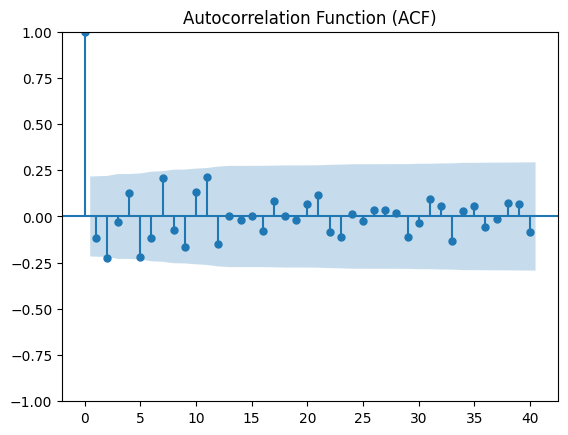

<Figure size 1200x600 with 0 Axes>

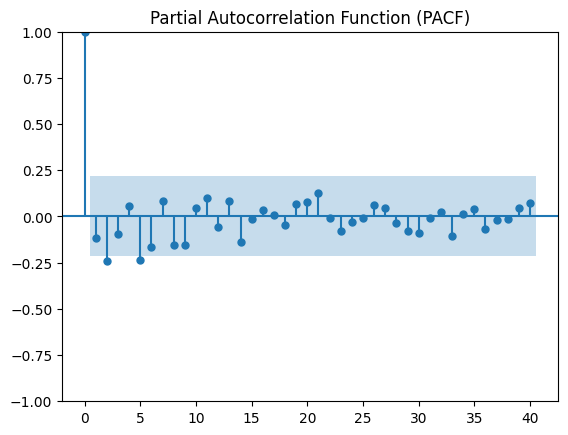


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   83
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -350.504
Date:                Mon, 14 Apr 2025   AIC                            723.008
Time:                        14:43:15   BIC                            749.482
Sample:                             0   HQIC                           733.637
                                 - 83                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1719      0.194      0.884      0.377      -0.209       0.553
ar.L2         -1.1826      0.241     -4.916      0.000      -1.654      -0.7

<Figure size 1200x600 with 0 Axes>

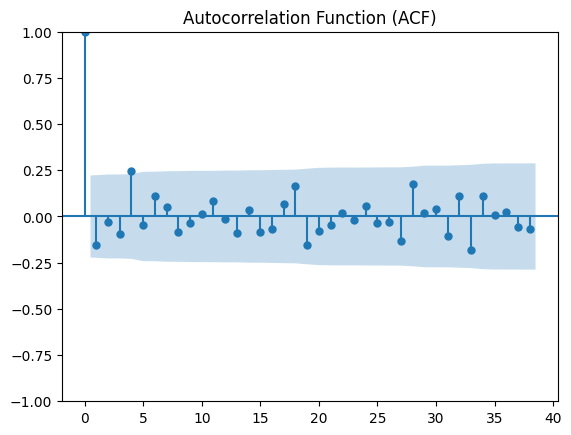

<Figure size 1200x600 with 0 Axes>

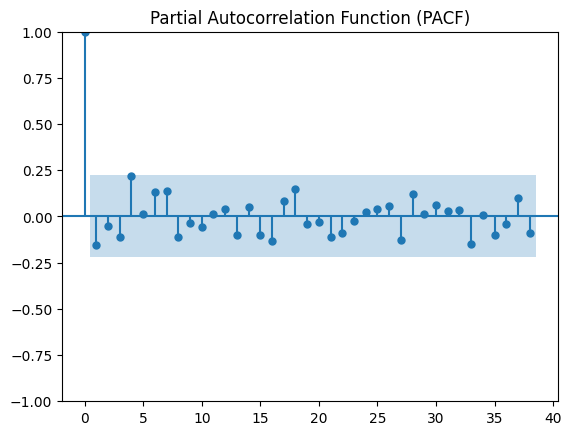


Fitting ARIMA model with order (1, 1, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   79
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -295.722
Date:                Mon, 14 Apr 2025   AIC                            597.444
Time:                        14:43:20   BIC                            604.514
Sample:                             0   HQIC                           600.274
                                 - 79                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0973      0.869      0.112      0.911      -1.607       1.801
ma.L1         -0.2504      0.85

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for ઘઉં લોકવન uploaded to Spaces at ml_models/commodities_saved_models/arima_model_87502194b76247425422d3d21be6173c.pkl
Model for ઘઉં લોકવન saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_87502194b76247425422d3d21be6173c.pkl
ઘઉં ટુકડા size:  79
False
Checking stationarity for the raw price data of ઘઉં ટુકડા:

ADF Test Results:
ADF Statistic: -0.4704
p-value: 0.8977
Critical Value 1%: -3.5183
Critical Value 5%: -2.8999
Critical Value 10%: -2.5872
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -10.9908
p-value: 0.0000
Critical Value 1%: -3.5183
Critical Value 5%: -2.8999
Critical Value 10%: -2.5872
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -10.9908
p-value: 0.0000
Critical Value 1%: -3.5183
Critical Value 5%: -2.8999
Critical Value 10%: -2.5872
The series is stationary (no further

<Figure size 1200x600 with 0 Axes>

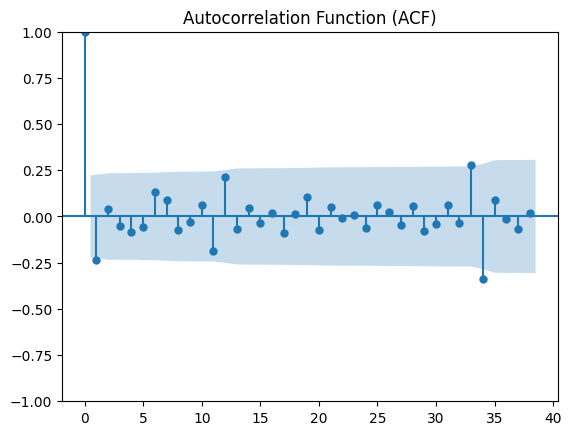

<Figure size 1200x600 with 0 Axes>

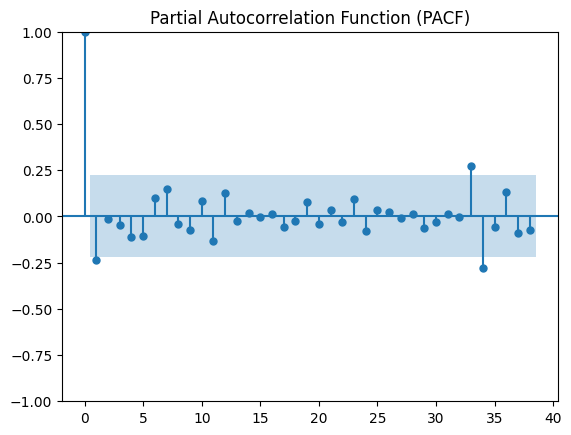


Fitting ARIMA model with order (4, 1, 2)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   79
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -333.494
Date:                Mon, 14 Apr 2025   AIC                            680.988
Time:                        14:43:24   BIC                            697.485
Sample:                             0   HQIC                           687.592
                                 - 79                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7450      0.123      6.069      0.000       0.504       0.986
ar.L2         -0.6518      0.13

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

Model for ઘઉં ટુકડા uploaded to Spaces at ml_models/commodities_saved_models/arima_model_8ceef4d416fd107ab6c25f46c19ae5da.pkl
Model for ઘઉં ટુકડા saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_8ceef4d416fd107ab6c25f46c19ae5da.pkl
મગફળી જીણી size:  82
False
Checking stationarity for the raw price data of મગફળી જીણી:

ADF Test Results:
ADF Statistic: -1.3939
p-value: 0.5852
Critical Value 1%: -3.5171
Critical Value 5%: -2.8994
Critical Value 10%: -2.5870
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -8.5158
p-value: 0.0000
Critical Value 1%: -3.5171
Critical Value 5%: -2.8994
Critical Value 10%: -2.5870
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -8.5158
p-value: 0.0000
Critical Value 1%: -3.5171
Critical Value 5%: -2.8994
Critical Value 10%: -2.5870
The series is stationary (no further

<Figure size 1200x600 with 0 Axes>

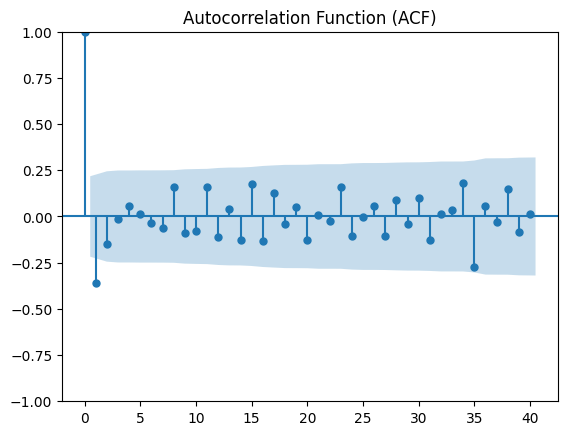

<Figure size 1200x600 with 0 Axes>

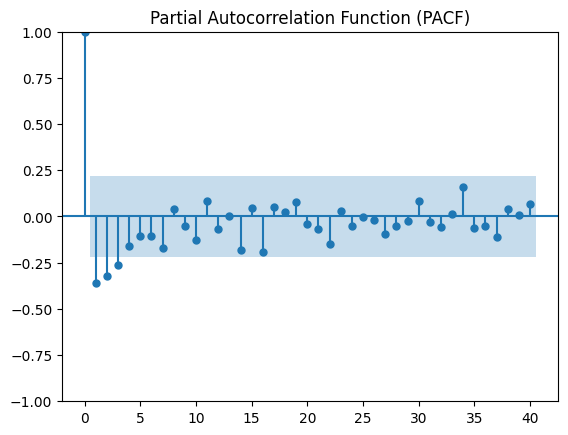


Fitting ARIMA model with order (2, 1, 2)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   82
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -302.560
Date:                Mon, 14 Apr 2025   AIC                            615.120
Time:                        14:43:28   BIC                            627.092
Sample:                             0   HQIC                           619.924
                                 - 82                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7421      0.775      0.958      0.338      -0.776       2.260
ar.L2         -0.2218      0.20

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for મગફળી જીણી uploaded to Spaces at ml_models/commodities_saved_models/arima_model_76918a89b8bd994063b1e687c029250c.pkl
Model for મગફળી જીણી saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_76918a89b8bd994063b1e687c029250c.pkl
સિંગ ફાડીયા size:  85
False
Checking stationarity for the raw price data of સિંગ ફાડીયા:

ADF Test Results:
ADF Statistic: -0.7506
p-value: 0.8332
Critical Value 1%: -3.5183
Critical Value 5%: -2.8999
Critical Value 10%: -2.5872
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -7.0047
p-value: 0.0000
Critical Value 1%: -3.5183
Critical Value 5%: -2.8999
Critical Value 10%: -2.5872
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -7.0047
p-value: 0.0000
Critical Value 1%: -3.5183
Critical Value 5%: -2.8999
Critical Value 10%: -2.5872
The series is stationary (no fur

<Figure size 1200x600 with 0 Axes>

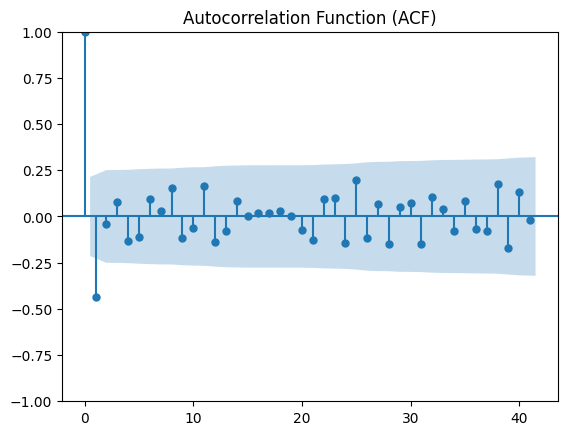

<Figure size 1200x600 with 0 Axes>

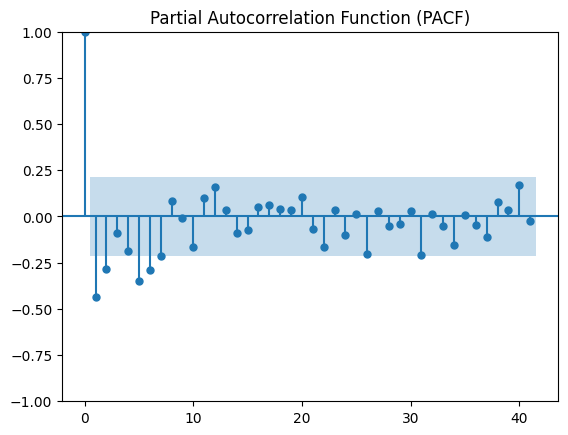


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   85
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -416.968
Date:                Mon, 14 Apr 2025   AIC                            847.936
Time:                        14:43:32   BIC                            864.952
Sample:                             0   HQIC                           854.777
                                 - 85                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1340      0.168      0.798      0.425      -0.195       0.463
ar.L2         -0.8182      0.111     -7.389      0.000      -1.035      -0.6

<Figure size 1200x600 with 0 Axes>

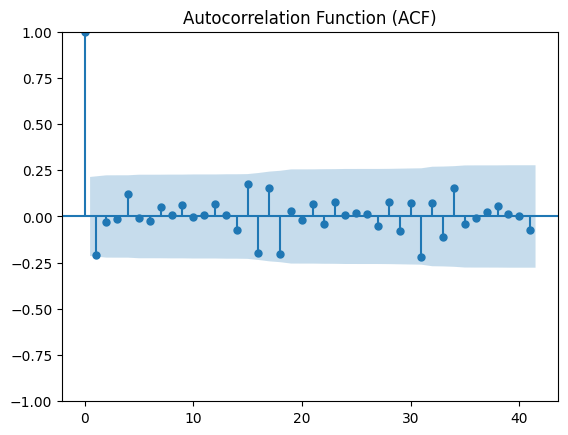

<Figure size 1200x600 with 0 Axes>

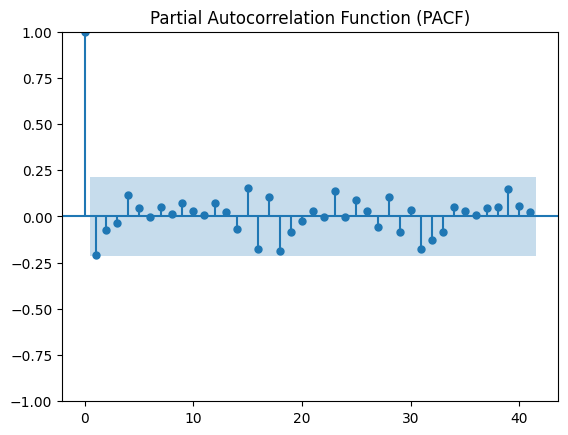


Fitting ARIMA model with order (3, 1, 3)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   85
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -354.553
Date:                Mon, 14 Apr 2025   AIC                            723.105
Time:                        14:43:36   BIC                            740.121
Sample:                             0   HQIC                           729.946
                                 - 85                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3977      1.012     -0.393      0.694      -2.382       1.586
ar.L2         -0.4414      0.67

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for એરંડા / એરંડી uploaded to Spaces at ml_models/commodities_saved_models/arima_model_0e3fdde6c1a0062af52b0d30296682b4.pkl
Model for એરંડા / એરંડી saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_0e3fdde6c1a0062af52b0d30296682b4.pkl
જીરૂ size:  73
False
Checking stationarity for the raw price data of જીરૂ:

ADF Test Results:
ADF Statistic: -3.6105
p-value: 0.0056
Critical Value 1%: -3.5260
Critical Value 5%: -2.9032
Critical Value 10%: -2.5890
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -3.6105
p-value: 0.0056
Critical Value 1%: -3.5260
Critical Value 5%: -2.9032
Critical Value 10%: -2.5890
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 0 at lags []
Significant spikes in PACF (p): 0 at lags []


<Figure size 1200x600 with 0 Axes>

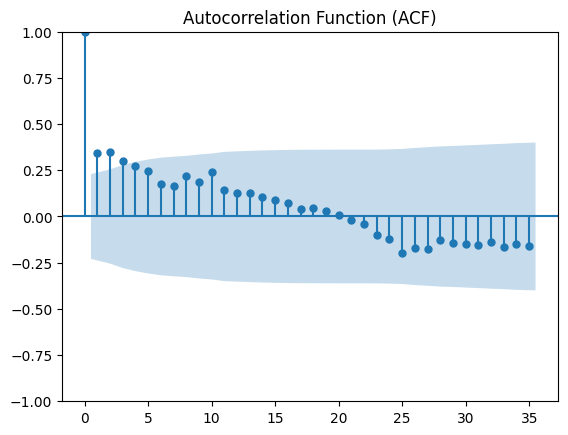

<Figure size 1200x600 with 0 Axes>

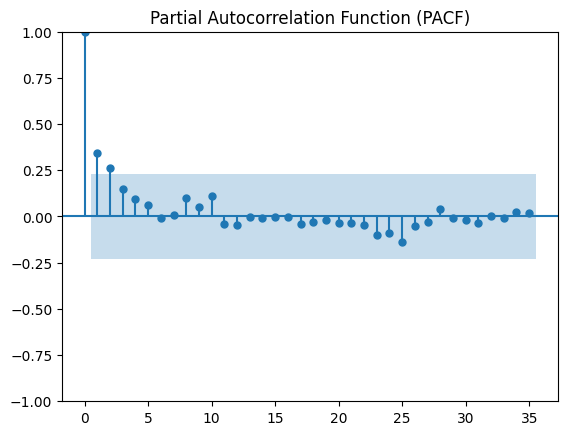


Fitting ARIMA model with order (0, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   73
Model:                          ARIMA   Log Likelihood                -558.179
Date:                Mon, 14 Apr 2025   AIC                           1120.358
Time:                        14:43:40   BIC                           1124.939
Sample:                             0   HQIC                          1122.184
                                 - 73                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4104.0820    117.597     34.900      0.000    3873.597    4334.567
sigma2      2.564e+05    1.9e+0

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for જીરૂ uploaded to Spaces at ml_models/commodities_saved_models/arima_model_705ea0772a9b99e73230d9c9741dad00.pkl
Model for જીરૂ saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_705ea0772a9b99e73230d9c9741dad00.pkl
વરીયાળી size:  56
True
Checking stationarity for the raw price data of વરીયાળી:

ADF Test Results:
ADF Statistic: -6.2995
p-value: 0.0000
Critical Value 1%: -3.5553
Critical Value 5%: -2.9157
Critical Value 10%: -2.5957
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -6.2995
p-value: 0.0000
Critical Value 1%: -3.5553
Critical Value 5%: -2.9157
Critical Value 10%: -2.5957
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 2 at lags [6 7]
Significant spikes in PACF (p): 4 at lags [ 6  7 12 15]


<Figure size 1200x600 with 0 Axes>

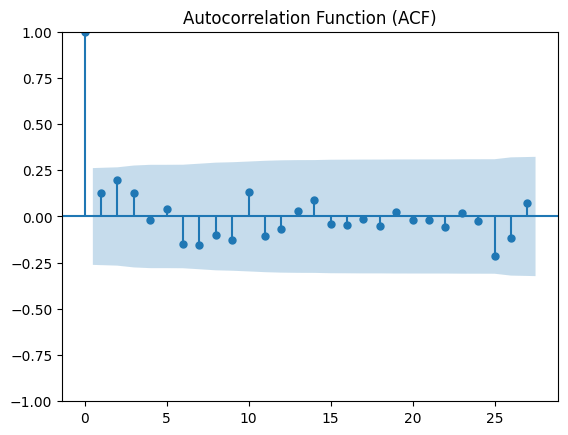

<Figure size 1200x600 with 0 Axes>

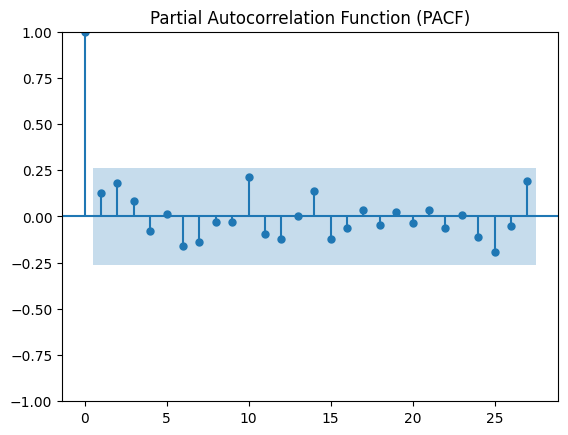


Fitting ARIMA model with order (4, 0, 2)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   56
Model:                 ARIMA(4, 0, 2)   Log Likelihood                -402.046
Date:                Mon, 14 Apr 2025   AIC                            820.091
Time:                        14:43:43   BIC                            836.294
Sample:                             0   HQIC                           826.373
                                 - 56                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1326.9690     88.614     14.975      0.000    1153.288    1500.650
ar.L1          0.4965      0.21

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

Model for વરીયાળી uploaded to Spaces at ml_models/commodities_saved_models/arima_model_b29d8bd88f2fbd8fa25597b22f5f5a06.pkl
Model for વરીયાળી saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_b29d8bd88f2fbd8fa25597b22f5f5a06.pkl
ધાણા size:  80
False
Checking stationarity for the raw price data of ધાણા:

ADF Test Results:
ADF Statistic: -2.9390
p-value: 0.0410
Critical Value 1%: -3.5171
Critical Value 5%: -2.8994
Critical Value 10%: -2.5870
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -2.9390
p-value: 0.0410
Critical Value 1%: -3.5171
Critical Value 5%: -2.8994
Critical Value 10%: -2.5870
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 3 at lags [17 18 19]
Significant spikes in PACF (p): 4 at lags [ 6  9 11 17]


<Figure size 1200x600 with 0 Axes>

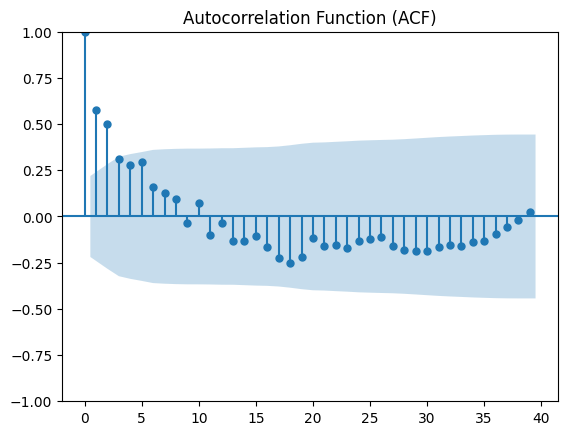

<Figure size 1200x600 with 0 Axes>

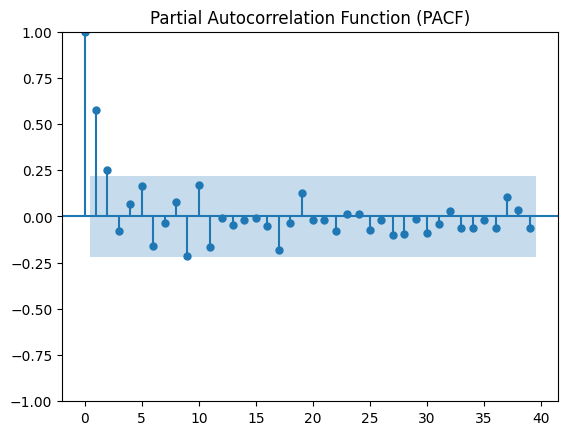


Fitting ARIMA model with order (4, 0, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   80
Model:                 ARIMA(4, 0, 3)   Log Likelihood                -412.415
Date:                Mon, 14 Apr 2025   AIC                            842.830
Time:                        14:43:46   BIC                            864.268
Sample:                             0   HQIC                           851.425
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1474.1852     29.882     49.333      0.000    1415.617    1532.753
ar.L1         -0.2491      3.289     -0.076      0.940      -6.695       6.1

<Figure size 1200x600 with 0 Axes>

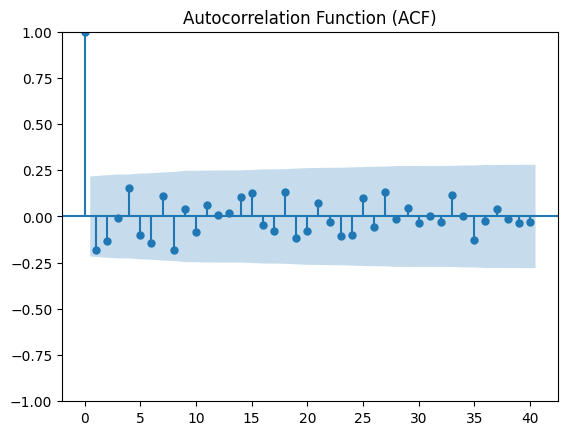

<Figure size 1200x600 with 0 Axes>

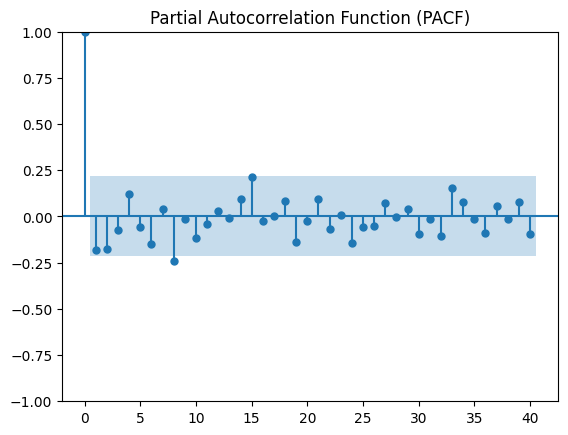


Fitting ARIMA model with order (4, 1, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   83
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -550.219
Date:                Mon, 14 Apr 2025   AIC                           1118.438
Time:                        14:43:50   BIC                           1140.099
Sample:                             0   HQIC                          1127.135
                                 - 83                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7880      0.204     -3.870      0.000      -1.187      -0.389
ar.L2         -1.3281      0.198     -6.694      0.000      -1.717      -0.9

<Figure size 1200x600 with 0 Axes>

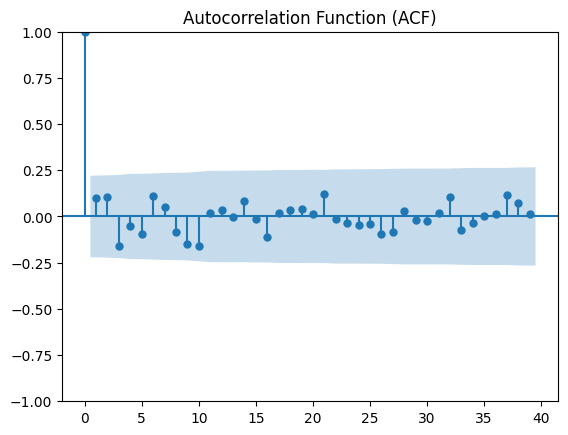

<Figure size 1200x600 with 0 Axes>

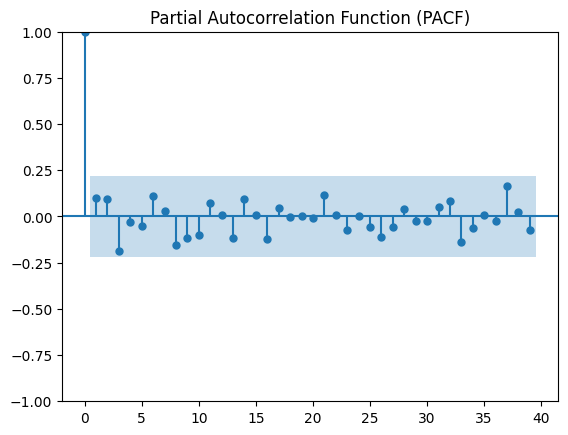


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   80
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -392.870
Date:                Mon, 14 Apr 2025   AIC                            799.740
Time:                        14:43:56   BIC                            816.326
Sample:                             0   HQIC                           806.385
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3620      0.877      0.413      0.680      -1.357       2.081
ar.L2         -0.2417      0.877     -0.276      0.783      -1.960       1.4

<Figure size 1200x600 with 0 Axes>

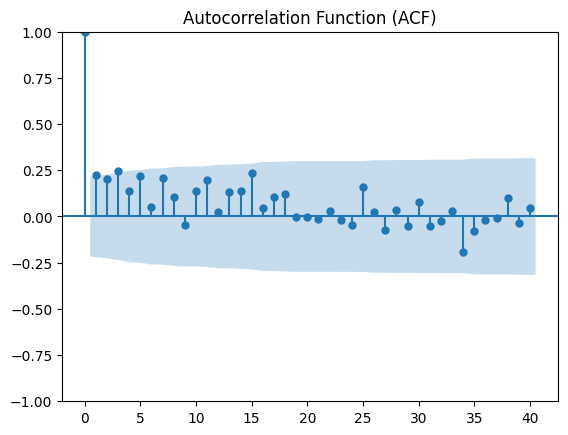

<Figure size 1200x600 with 0 Axes>

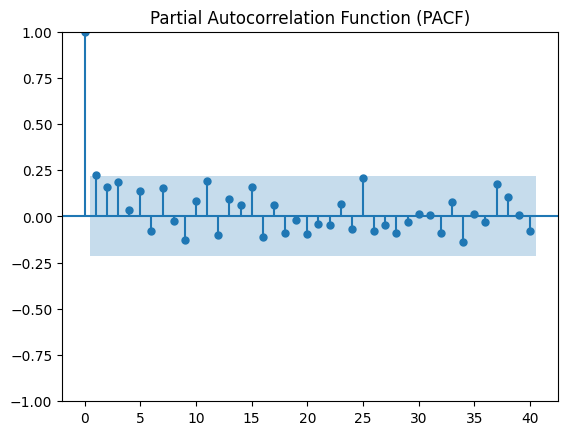


Fitting ARIMA model with order (4, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   82
Model:                 ARIMA(4, 0, 0)   Log Likelihood                -490.266
Date:                Mon, 14 Apr 2025   AIC                            992.532
Time:                        14:44:00   BIC                           1006.972
Sample:                             0   HQIC                           998.329
                                 - 82                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1490.9206     29.981     49.729      0.000    1432.159    1549.682
ar.L1          0.1443      0.13

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for અડદ uploaded to Spaces at ml_models/commodities_saved_models/arima_model_8da1a95f4bb531016b344a0140f7d4aa.pkl
Model for અડદ saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_8da1a95f4bb531016b344a0140f7d4aa.pkl
મઠ size:  54
False
Checking stationarity for the raw price data of મઠ:

ADF Test Results:
ADF Statistic: -2.6628
p-value: 0.0807
Critical Value 1%: -3.5629
Critical Value 5%: -2.9190
Critical Value 10%: -2.5974
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -6.3666
p-value: 0.0000
Critical Value 1%: -3.5656
Critical Value 5%: -2.9201
Critical Value 10%: -2.5980
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -6.3666
p-value: 0.0000
Critical Value 1%: -3.5656
Critical Value 5%: -2.9201
Critical Value 10%: -2.5980
The series is stationary (no further differencing needed).
Signi

<Figure size 1200x600 with 0 Axes>

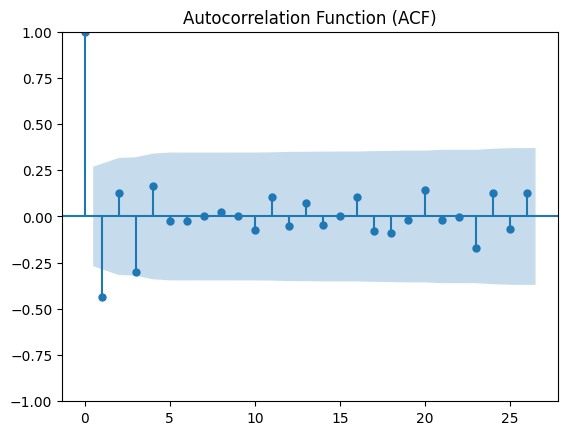

<Figure size 1200x600 with 0 Axes>

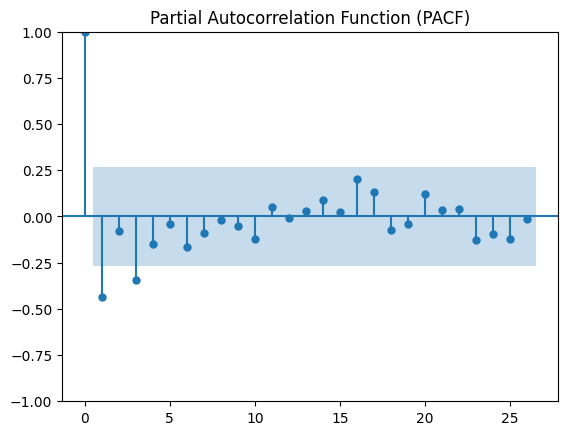


Fitting ARIMA model with order (5, 1, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   54
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -352.207
Date:                Mon, 14 Apr 2025   AIC                            720.414
Time:                        14:44:04   BIC                            736.176
Sample:                             0   HQIC                           726.475
                                 - 54                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5653      7.495     -0.075      0.940     -15.256      14.125
ar.L2          0.6323      3.280      0.193      0.847      -5.797       7.0

<Figure size 1200x600 with 0 Axes>

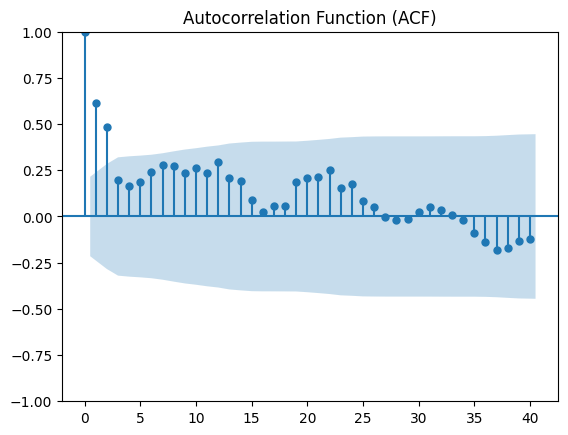

<Figure size 1200x600 with 0 Axes>

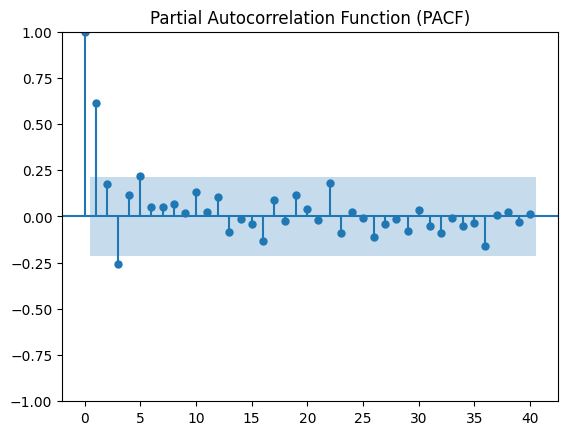


Fitting ARIMA model with order (2, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   83
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -500.463
Date:                Mon, 14 Apr 2025   AIC                           1008.926
Time:                        14:44:08   BIC                           1018.601
Sample:                             0   HQIC                          1012.813
                                 - 83                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1475.2030     61.795     23.873      0.000    1354.088    1596.318
ar.L1          0.4953      0.08

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for તુવેર uploaded to Spaces at ml_models/commodities_saved_models/arima_model_2b0b6c6c9287c5c4ef5113cf987a1d9b.pkl
Model for તુવેર saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_2b0b6c6c9287c5c4ef5113cf987a1d9b.pkl
રાજગરો size:  11
False
Checking stationarity for the raw price data of રાજગરો:

ADF Test Results:
ADF Statistic: -0.8013
p-value: 0.8187
Critical Value 1%: -4.6652
Critical Value 5%: -3.3672
Critical Value 10%: -2.8030
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -4.5016
p-value: 0.0002
Critical Value 1%: -5.3543
Critical Value 5%: -3.6462
Critical Value 10%: -2.9012
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -4.5016
p-value: 0.0002
Critical Value 1%: -5.3543
Critical Value 5%: -3.6462
Critical Value 10%: -2.9012
The series is stationary (no further differencing ne

<Figure size 1200x600 with 0 Axes>

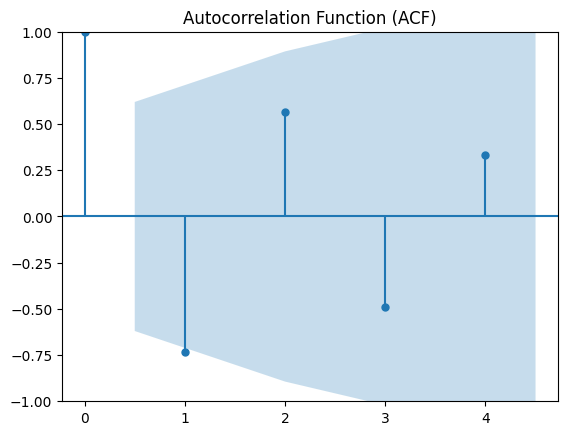

<Figure size 1200x600 with 0 Axes>

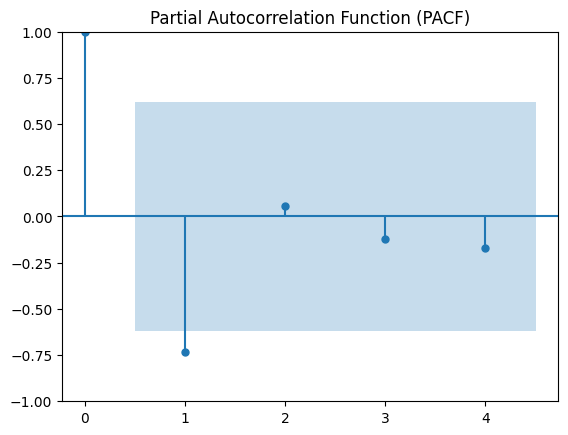


Fitting ARIMA model with order (2, 1, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   11
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 -64.666
Date:                Mon, 14 Apr 2025   AIC                            137.332
Time:                        14:44:10   BIC                            138.542
Sample:                             0   HQIC                           136.004
                                 - 11                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7813      1.265     -1.409      0.159      -4.260       0.697
ar.L2         -0.8322      1.04

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

Model for રાજગરો uploaded to Spaces at ml_models/commodities_saved_models/arima_model_533fcfa2f0fde6df6346b5d24501580a.pkl
Model for રાજગરો saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_533fcfa2f0fde6df6346b5d24501580a.pkl
મેથી size:  82
False
Checking stationarity for the raw price data of મેથી:

ADF Test Results:
ADF Statistic: -3.4721
p-value: 0.0087
Critical Value 1%: -3.5149
Critical Value 5%: -2.8984
Critical Value 10%: -2.5864
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -3.4721
p-value: 0.0087
Critical Value 1%: -3.5149
Critical Value 5%: -2.8984
Critical Value 10%: -2.5864
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 3 at lags [13 15 18]
Significant spikes in PACF (p): 5 at lags [ 8 12 13 15 18]


<Figure size 1200x600 with 0 Axes>

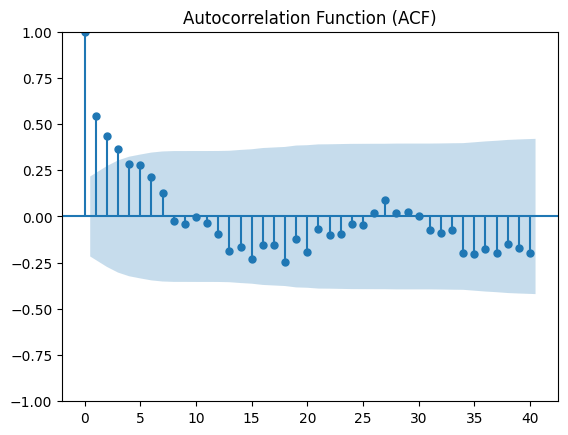

<Figure size 1200x600 with 0 Axes>

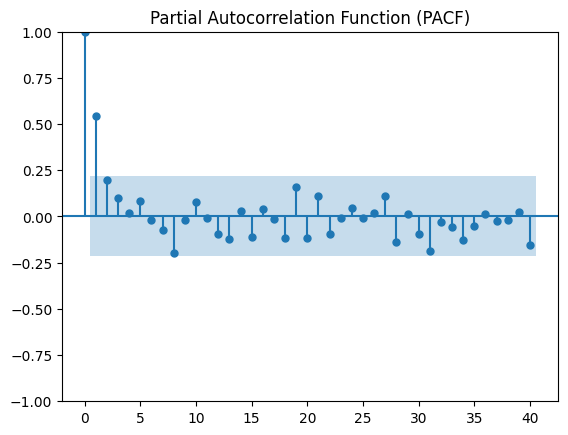


Fitting ARIMA model with order (5, 0, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   82
Model:                 ARIMA(5, 0, 3)   Log Likelihood                -481.637
Date:                Mon, 14 Apr 2025   AIC                            983.275
Time:                        14:44:12   BIC                           1007.342
Sample:                             0   HQIC                           992.937
                                 - 82                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        963.2941     31.259     30.816      0.000     902.027    1024.561
ar.L1          0.2245      0.219      1.027      0.304      -0.204       0.6

<Figure size 1200x600 with 0 Axes>

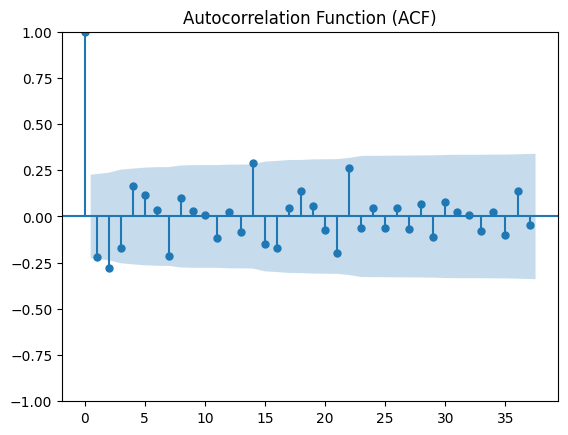

<Figure size 1200x600 with 0 Axes>

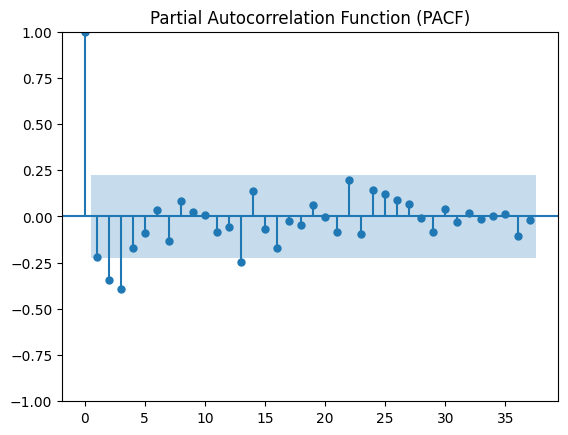


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   76
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -488.199
Date:                Mon, 14 Apr 2025   AIC                            998.399
Time:                        14:44:17   BIC                           1023.891
Sample:                             0   HQIC                          1008.578
                                 - 76                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8421      0.781     -1.078      0.281      -2.374       0.689
ar.L2         -0.8691      0.402     -2.163      0.031      -1.657      -0.0

<Figure size 1200x600 with 0 Axes>

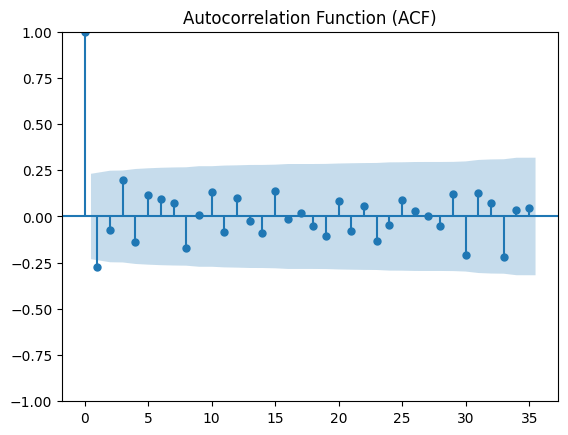

<Figure size 1200x600 with 0 Axes>

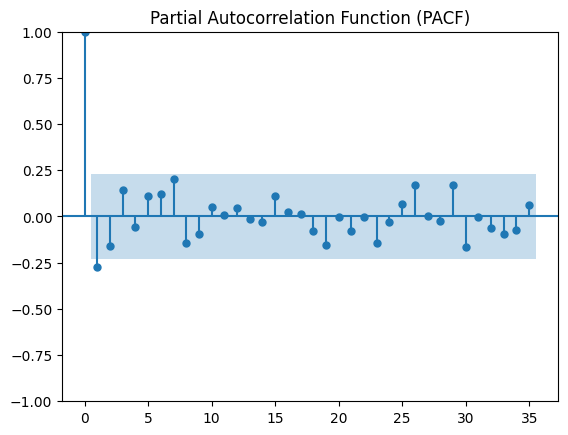


Fitting ARIMA model with order (3, 1, 3)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   73
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -417.114
Date:                Mon, 14 Apr 2025   AIC                            848.229
Time:                        14:44:22   BIC                            864.165
Sample:                             0   HQIC                           854.573
                                 - 73                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0953      0.377      0.253      0.801      -0.644       0.835
ar.L2          0.5791      0.37

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

Model for મરચા uploaded to Spaces at ml_models/commodities_saved_models/arima_model_d3b83550bfe0f8e9480b3ba70fd732f2.pkl
Model for મરચા saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_d3b83550bfe0f8e9480b3ba70fd732f2.pkl
મગફળી જાડી size:  82
False
Checking stationarity for the raw price data of મગફળી જાડી:

ADF Test Results:
ADF Statistic: -1.7461
p-value: 0.4075
Critical Value 1%: -3.5149
Critical Value 5%: -2.8984
Critical Value 10%: -2.5864
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -13.6914
p-value: 0.0000
Critical Value 1%: -3.5149
Critical Value 5%: -2.8984
Critical Value 10%: -2.5864
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -13.6914
p-value: 0.0000
Critical Value 1%: -3.5149
Critical Value 5%: -2.8984
Critical Value 10%: -2.5864
The series is stationary (no further differe

<Figure size 1200x600 with 0 Axes>

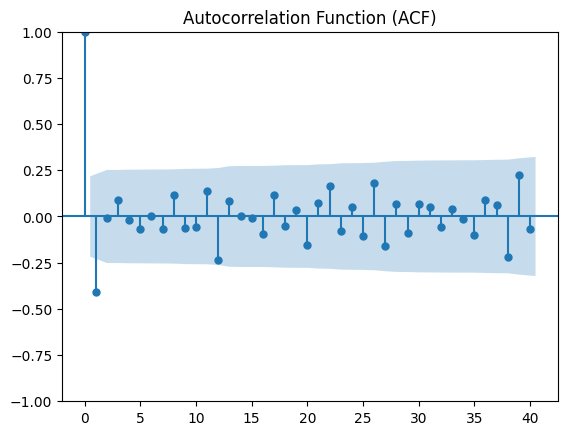

<Figure size 1200x600 with 0 Axes>

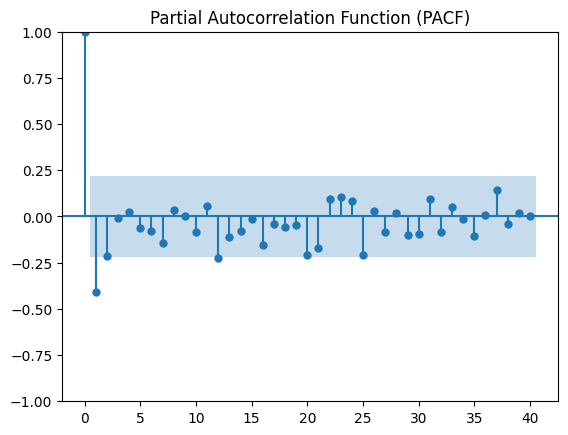


Fitting ARIMA model with order (2, 1, 2)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   82
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -286.661
Date:                Mon, 14 Apr 2025   AIC                            583.322
Time:                        14:44:26   BIC                            595.295
Sample:                             0   HQIC                           588.126
                                 - 82                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2930      0.997     -0.294      0.769      -2.248       1.662
ar.L2         -0.2418      0.32

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for મગફળી જાડી uploaded to Spaces at ml_models/commodities_saved_models/arima_model_63f9bef57ceb96566040d4fcf61cc68b.pkl
Model for મગફળી જાડી saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_63f9bef57ceb96566040d4fcf61cc68b.pkl
સફેદ ચણા size:  81
True
Checking stationarity for the raw price data of સફેદ ચણા:

ADF Test Results:
ADF Statistic: -2.3934
p-value: 0.1436
Critical Value 1%: -3.5160
Critical Value 5%: -2.8989
Critical Value 10%: -2.5867
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -6.5242
p-value: 0.0000
Critical Value 1%: -3.5195
Critical Value 5%: -2.9004
Critical Value 10%: -2.5875
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -6.5242
p-value: 0.0000
Critical Value 1%: -3.5195
Critical Value 5%: -2.9004
Critical Value 10%: -2.5875
The series is stationary (no further di

<Figure size 1200x600 with 0 Axes>

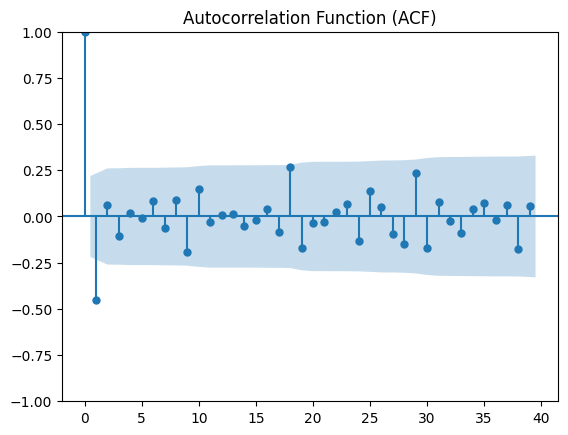

<Figure size 1200x600 with 0 Axes>

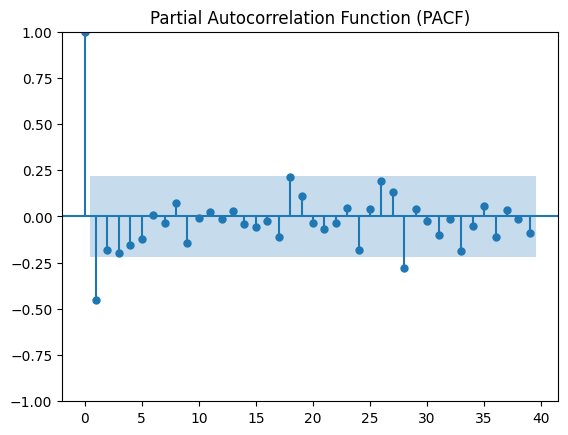


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   81
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -517.739
Date:                Mon, 14 Apr 2025   AIC                           1049.478
Time:                        14:44:29   BIC                           1066.152
Sample:                             0   HQIC                          1056.163
                                 - 81                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0466      1.655      0.028      0.978      -3.197       3.291
ar.L2          0.5503      1.080      0.510      0.610      -1.566       2.6

<Figure size 1200x600 with 0 Axes>

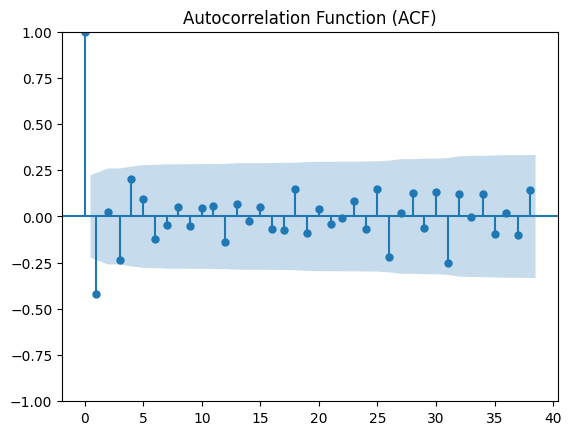

<Figure size 1200x600 with 0 Axes>

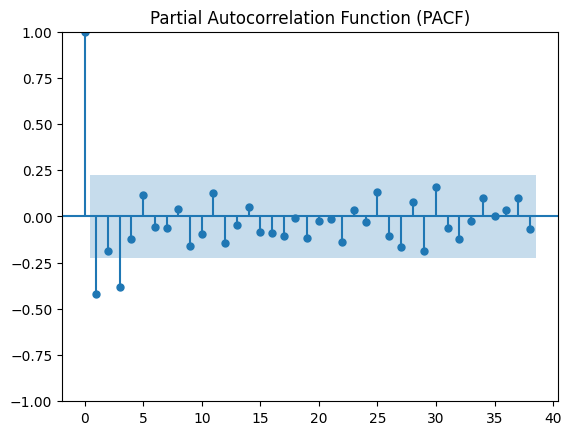


Fitting ARIMA model with order (2, 1, 2)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   78
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -466.268
Date:                Mon, 14 Apr 2025   AIC                            942.537
Time:                        14:44:34   BIC                            954.256
Sample:                             0   HQIC                           947.224
                                 - 78                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5467      1.008     -0.542      0.588      -2.522       1.429
ar.L2          0.1487      0.17

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for તલ - તલી uploaded to Spaces at ml_models/commodities_saved_models/arima_model_7e1ef0afc9707b6988035c60006378fd.pkl
Model for તલ - તલી saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_7e1ef0afc9707b6988035c60006378fd.pkl
ઇસબગુલ size:  26
False
Checking stationarity for the raw price data of ઇસબગુલ:

ADF Test Results:
ADF Statistic: -4.4902
p-value: 0.0002
Critical Value 1%: -3.7239
Critical Value 5%: -2.9865
Critical Value 10%: -2.6328
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -4.4902
p-value: 0.0002
Critical Value 1%: -3.7239
Critical Value 5%: -2.9865
Critical Value 10%: -2.6328
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 1 at lags [9]
Significant spikes in PACF (p): 3 at lags [ 3  9 12]


<Figure size 1200x600 with 0 Axes>

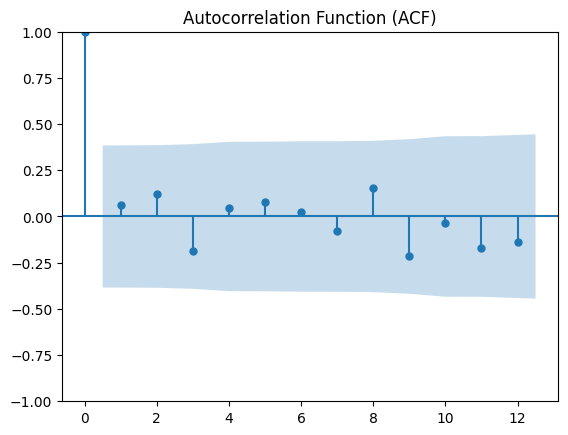

<Figure size 1200x600 with 0 Axes>

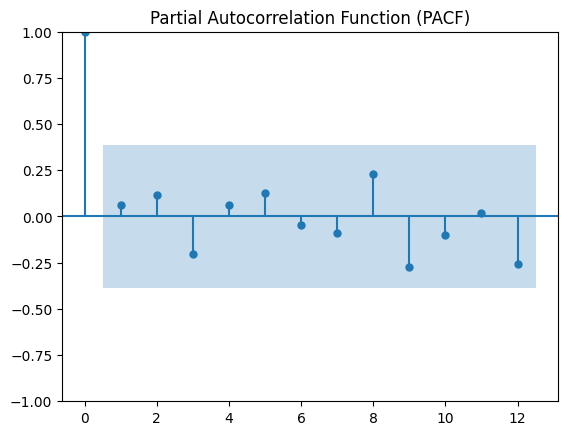


Fitting ARIMA model with order (3, 0, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   26
Model:                 ARIMA(3, 0, 1)   Log Likelihood                -186.044
Date:                Mon, 14 Apr 2025   AIC                            384.088
Time:                        14:44:37   BIC                            391.637
Sample:                             0   HQIC                           386.262
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1708.1751     89.432     19.100      0.000    1532.892    1883.458
ar.L1         -0.0053      1.05

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for ઇસબગુલ uploaded to Spaces at ml_models/commodities_saved_models/arima_model_677c5bca1c7d6ace1388141bdfb15765.pkl
Model for ઇસબગુલ saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_677c5bca1c7d6ace1388141bdfb15765.pkl
ધાણી size:  80
False
Checking stationarity for the raw price data of ધાણી:

ADF Test Results:
ADF Statistic: -3.6149
p-value: 0.0055
Critical Value 1%: -3.5160
Critical Value 5%: -2.8989
Critical Value 10%: -2.5867
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -3.6149
p-value: 0.0055
Critical Value 1%: -3.5160
Critical Value 5%: -2.8989
Critical Value 10%: -2.5867
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 1 at lags [18]
Significant spikes in PACF (p): 3 at lags [ 7  8 11]


<Figure size 1200x600 with 0 Axes>

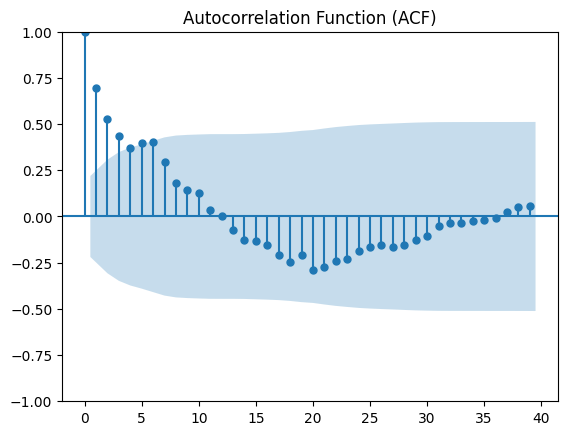

<Figure size 1200x600 with 0 Axes>

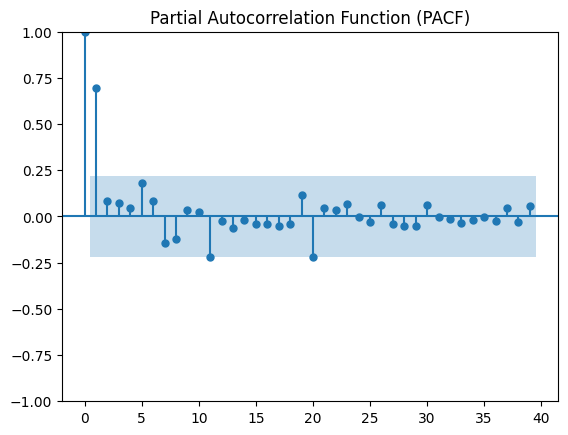


Fitting ARIMA model with order (3, 0, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   80
Model:                 ARIMA(3, 0, 1)   Log Likelihood                -467.457
Date:                Mon, 14 Apr 2025   AIC                            946.914
Time:                        14:44:39   BIC                            961.206
Sample:                             0   HQIC                           952.644
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1531.8320     96.984     15.795      0.000    1341.748    1721.917
ar.L1          1.2331      0.94

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for ધાણી uploaded to Spaces at ml_models/commodities_saved_models/arima_model_a57e8a934d618f6b945b16f338e01634.pkl
Model for ધાણી saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_a57e8a934d618f6b945b16f338e01634.pkl
ડુંગળી સફેદ size:  82
True
Checking stationarity for the raw price data of ડુંગળી સફેદ:

ADF Test Results:
ADF Statistic: -1.8206
p-value: 0.3703
Critical Value 1%: -3.5149
Critical Value 5%: -2.8984
Critical Value 10%: -2.5864
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -12.1033
p-value: 0.0000
Critical Value 1%: -3.5149
Critical Value 5%: -2.8984
Critical Value 10%: -2.5864
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -12.1033
p-value: 0.0000
Critical Value 1%: -3.5149
Critical Value 5%: -2.8984
Critical Value 10%: -2.5864
The series is stationary (no further differ

<Figure size 1200x600 with 0 Axes>

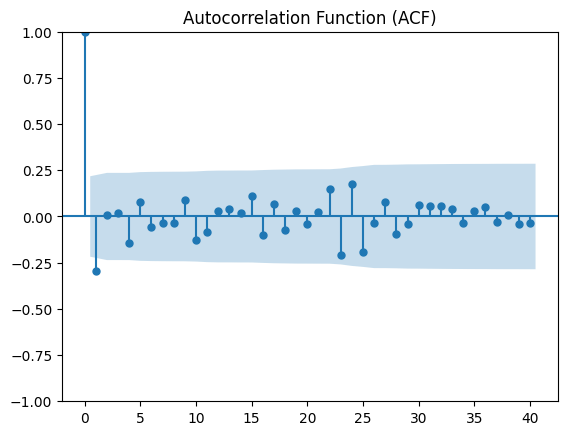

<Figure size 1200x600 with 0 Axes>

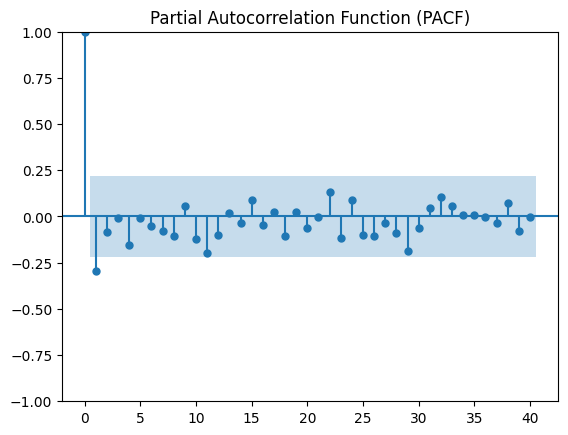


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   82
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -394.024
Date:                Mon, 14 Apr 2025   AIC                            802.049
Time:                        14:44:42   BIC                            818.810
Sample:                             0   HQIC                           808.774
                                 - 82                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6945      0.917     -0.757      0.449      -2.492       1.103
ar.L2          0.4364      0.871      0.501      0.616      -1.270       2.1

<Figure size 1200x600 with 0 Axes>

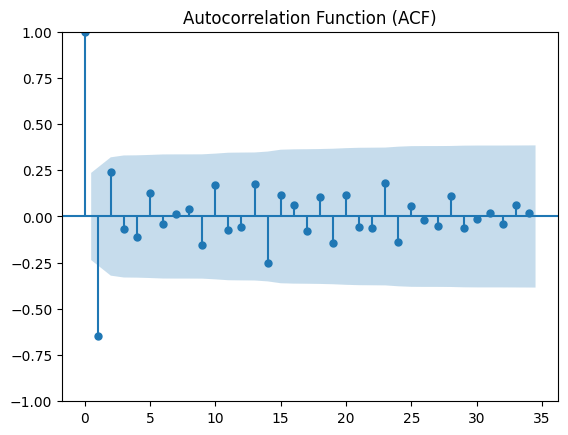

<Figure size 1200x600 with 0 Axes>

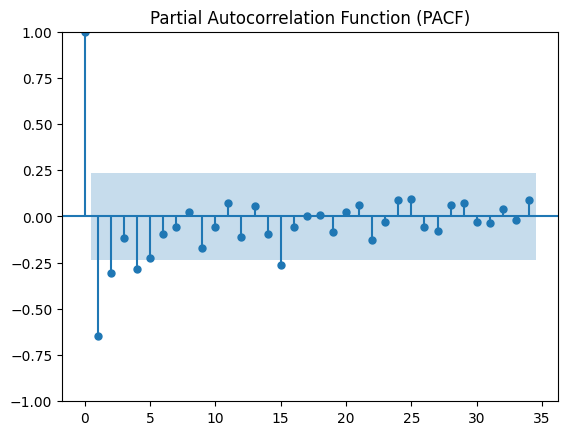


Fitting ARIMA model with order (2, 1, 2)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   70
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -371.819
Date:                Mon, 14 Apr 2025   AIC                            753.638
Time:                        14:44:46   BIC                            764.809
Sample:                             0   HQIC                           758.070
                                 - 70                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2107      1.906     -0.111      0.912      -3.946       3.525
ar.L2          0.0860      0.54

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for બાજરો uploaded to Spaces at ml_models/commodities_saved_models/arima_model_c3987e3cca4be9568a8318d74100d6cc.pkl
Model for બાજરો saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_c3987e3cca4be9568a8318d74100d6cc.pkl
જુવાર size:  80
False
Checking stationarity for the raw price data of જુવાર:

ADF Test Results:
ADF Statistic: -8.6213
p-value: 0.0000
Critical Value 1%: -3.5160
Critical Value 5%: -2.8989
Critical Value 10%: -2.5867
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -8.6213
p-value: 0.0000
Critical Value 1%: -3.5160
Critical Value 5%: -2.8989
Critical Value 10%: -2.5867
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 4 at lags [ 5 10 14 17]
Significant spikes in PACF (p): 4 at lags [ 5 10 14 17]


<Figure size 1200x600 with 0 Axes>

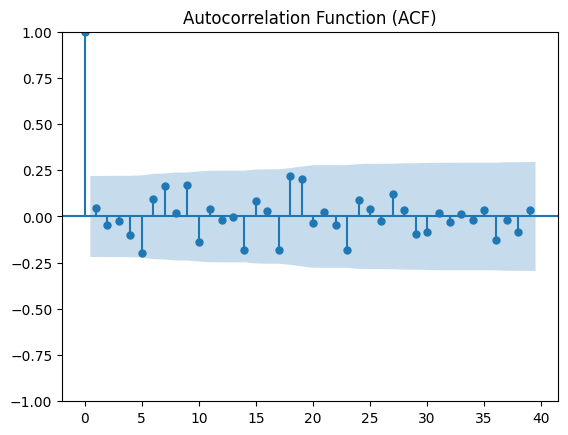

<Figure size 1200x600 with 0 Axes>

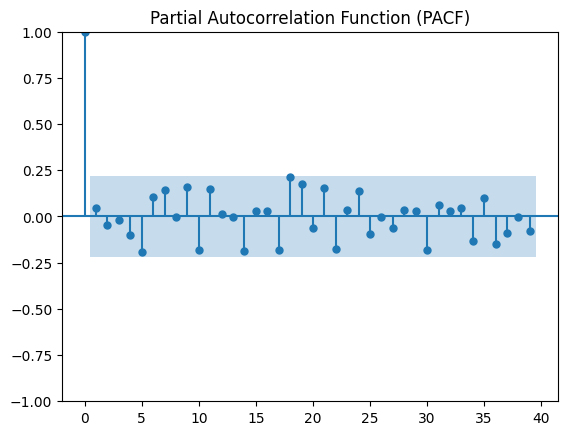


Fitting ARIMA model with order (4, 0, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   80
Model:                 ARIMA(4, 0, 4)   Log Likelihood                -512.604
Date:                Mon, 14 Apr 2025   AIC                           1045.207
Time:                        14:44:49   BIC                           1069.028
Sample:                             0   HQIC                          1054.758
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        757.2887     30.057     25.195      0.000     698.378     816.200
ar.L1         -0.1307      0.345     -0.379      0.705      -0.806       0.5

<Figure size 1200x600 with 0 Axes>

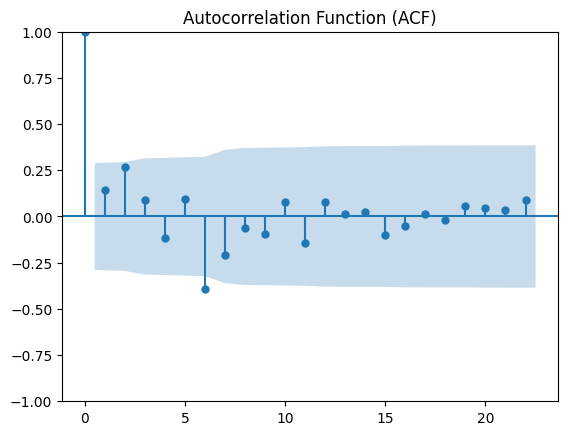

<Figure size 1200x600 with 0 Axes>

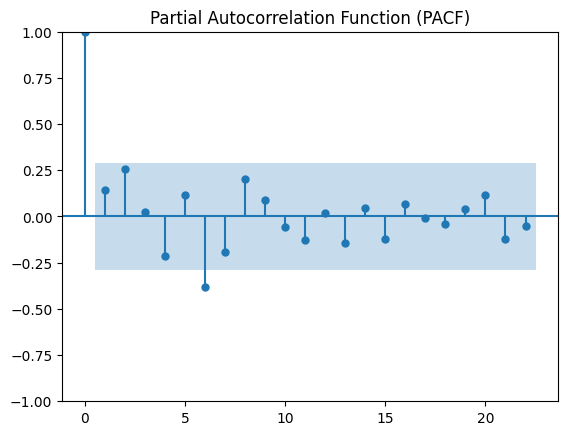


Fitting ARIMA model with order (2, 0, 2)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   46
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -242.531
Date:                Mon, 14 Apr 2025   AIC                            497.061
Time:                        14:44:53   BIC                            508.033
Sample:                             0   HQIC                           501.171
                                 - 46                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        496.0146     13.362     37.120      0.000     469.825     522.204
ar.L1         -0.3859      2.43

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

Model for મકાઇ uploaded to Spaces at ml_models/commodities_saved_models/arima_model_d6e42542a6883b5d65ce5b7fbccf4b9b.pkl
Model for મકાઇ saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_d6e42542a6883b5d65ce5b7fbccf4b9b.pkl
મગ size:  79
False
Checking stationarity for the raw price data of મગ:

ADF Test Results:
ADF Statistic: -1.6989
p-value: 0.4317
Critical Value 1%: -3.5220
Critical Value 5%: -2.9015
Critical Value 10%: -2.5881
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -8.9102
p-value: 0.0000
Critical Value 1%: -3.5220
Critical Value 5%: -2.9015
Critical Value 10%: -2.5881
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -8.9102
p-value: 0.0000
Critical Value 1%: -3.5220
Critical Value 5%: -2.9015
Critical Value 10%: -2.5881
The series is stationary (no further differencing needed).
Sig

<Figure size 1200x600 with 0 Axes>

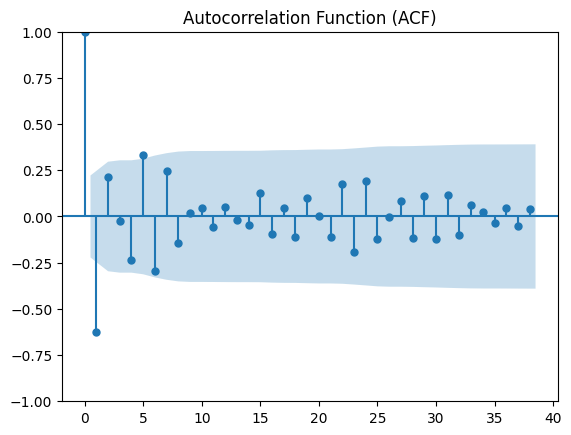

<Figure size 1200x600 with 0 Axes>

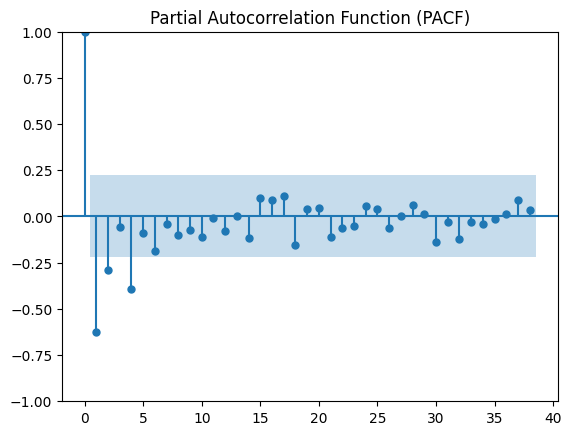


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   79
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -484.214
Date:                Mon, 14 Apr 2025   AIC                            982.428
Time:                        14:44:56   BIC                            998.925
Sample:                             0   HQIC                           989.032
                                 - 79                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5022      0.303     -4.955      0.000      -2.096      -0.908
ar.L2         -0.6759      0.391     -1.728      0.084      -1.442       0.0

<Figure size 1200x600 with 0 Axes>

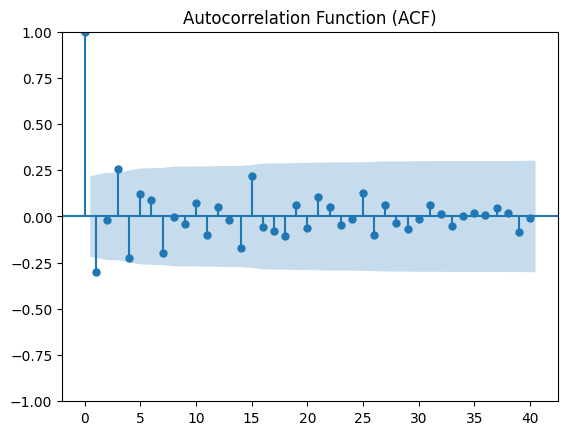

<Figure size 1200x600 with 0 Axes>

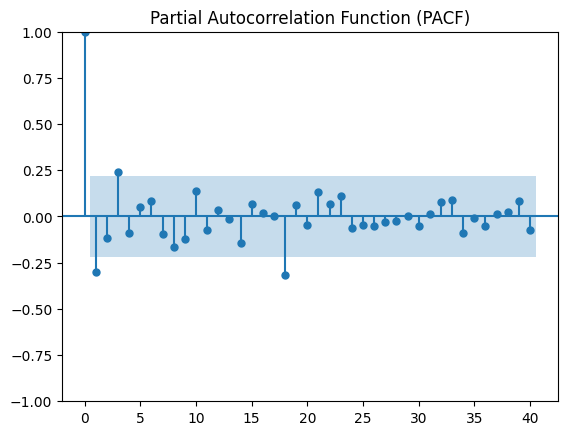


Fitting ARIMA model with order (4, 1, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   82
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -372.415
Date:                Mon, 14 Apr 2025   AIC                            762.831
Time:                        14:45:00   BIC                            784.381
Sample:                             0   HQIC                           771.477
                                 - 82                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3861      0.168     -2.292      0.022      -0.716      -0.056
ar.L2          0.3856      0.158      2.440      0.015       0.076       0.6

<Figure size 1200x600 with 0 Axes>

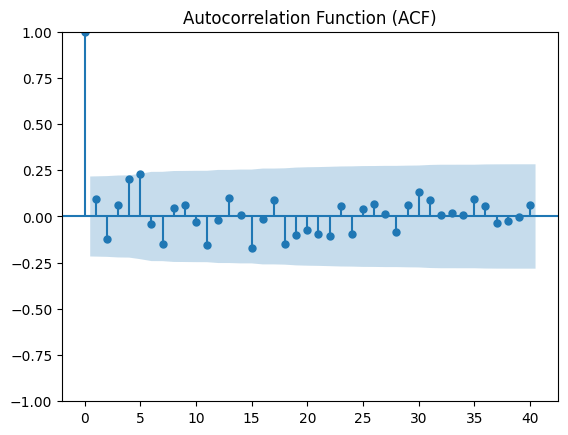

<Figure size 1200x600 with 0 Axes>

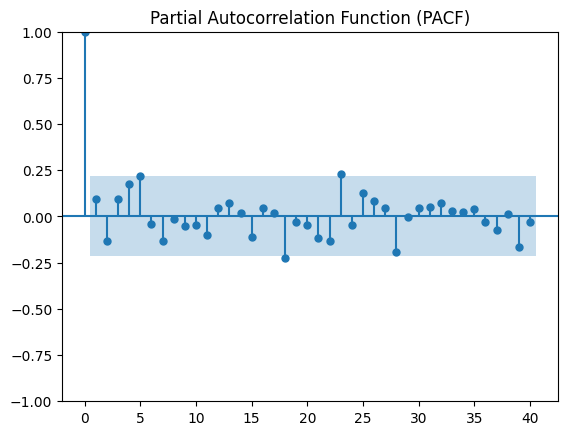


Fitting ARIMA model with order (5, 0, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   82
Model:                 ARIMA(5, 0, 5)   Log Likelihood                -529.417
Date:                Mon, 14 Apr 2025   AIC                           1082.833
Time:                        14:45:06   BIC                           1111.714
Sample:                             0   HQIC                          1094.428
                                 - 82                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1049.0682     37.744     27.794      0.000     975.092    1123.045
ar.L1          0.6107      0.416      1.468      0.142      -0.204       1.4

<Figure size 1200x600 with 0 Axes>

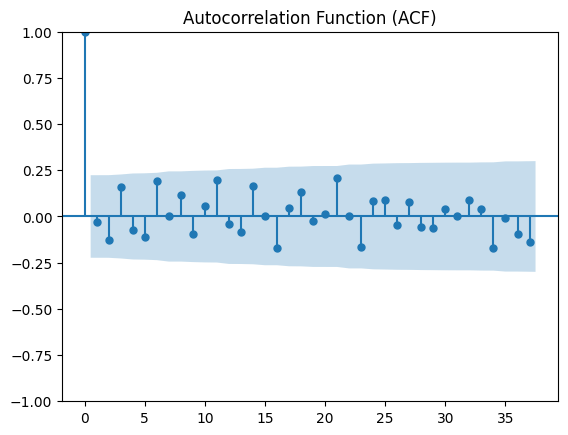

<Figure size 1200x600 with 0 Axes>

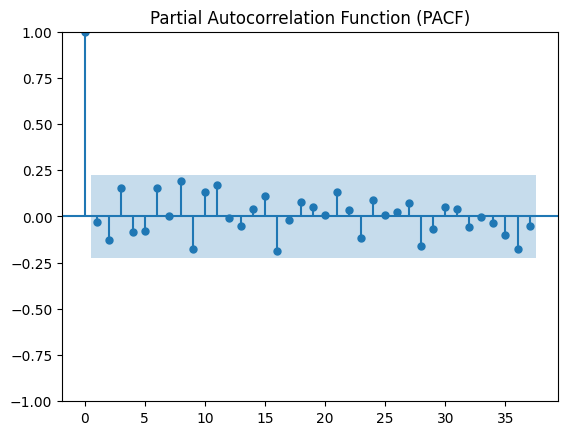


Fitting ARIMA model with order (3, 0, 2)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   77
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -575.340
Date:                Mon, 14 Apr 2025   AIC                           1164.680
Time:                        14:45:14   BIC                           1181.086
Sample:                             0   HQIC                          1171.242
                                 - 77                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1376.0909     55.358     24.858      0.000    1267.591    1484.590
ar.L1         -1.7175      0.18

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

Model for ચોળા / ચોળી uploaded to Spaces at ml_models/commodities_saved_models/arima_model_e811baf99bd82d8ea7eb6a9e22ec759b.pkl
Model for ચોળા / ચોળી saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_e811baf99bd82d8ea7eb6a9e22ec759b.pkl
સોયાબીન size:  81
False
Checking stationarity for the raw price data of સોયાબીન:

ADF Test Results:
ADF Statistic: -2.0061
p-value: 0.2839
Critical Value 1%: -3.5274
Critical Value 5%: -2.9038
Critical Value 10%: -2.5893
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -0.8230
p-value: 0.8123
Critical Value 1%: -3.5274
Critical Value 5%: -2.9038
Critical Value 10%: -2.5893
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -6.8998
p-value: 0.0000
Critical Value 1%: -3.5274
Critical Value 5%: -2.9038
Critical Value 10%: -2.5893
The series is stationary (no further differencing needed).
Data is stationary with d=2.

Checking stationarity for the

<Figure size 1200x600 with 0 Axes>

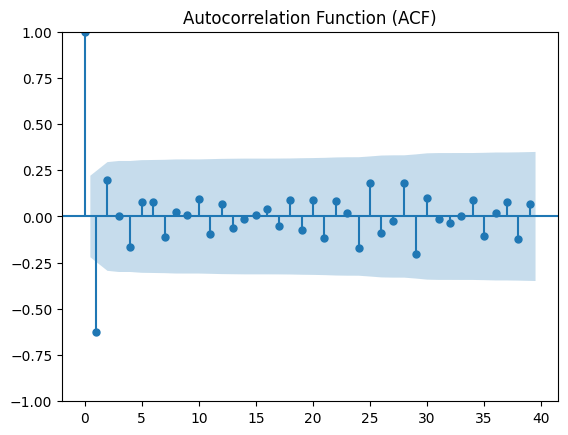

<Figure size 1200x600 with 0 Axes>

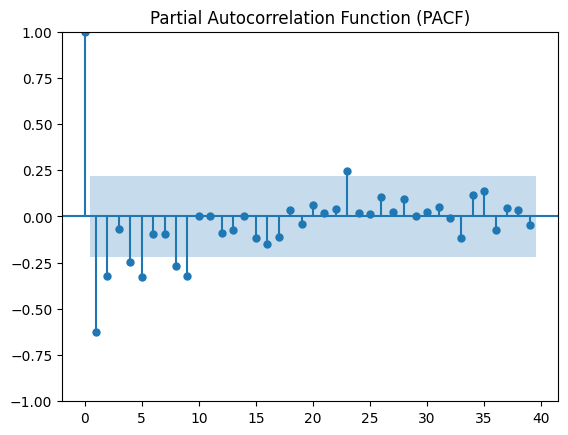


Fitting ARIMA model with order (2, 2, 2)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   81
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -308.903
Date:                Mon, 14 Apr 2025   AIC                            627.806
Time:                        14:45:17   BIC                            639.653
Sample:                             0   HQIC                           632.552
                                 - 81                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1737      2.014     -0.086      0.931      -4.121       3.773
ar.L2          0.0953      0.38

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for સોયાબીન uploaded to Spaces at ml_models/commodities_saved_models/arima_model_de6ba296c96edc3d9fa907b7b9d72010.pkl
Model for સોયાબીન saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_de6ba296c96edc3d9fa907b7b9d72010.pkl
અજમાં size:  17
False
Checking stationarity for the raw price data of અજમાં:

ADF Test Results:
ADF Statistic: -4.2804
p-value: 0.0005
Critical Value 1%: -3.9240
Critical Value 5%: -3.0685
Critical Value 10%: -2.6739
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -4.2804
p-value: 0.0005
Critical Value 1%: -3.9240
Critical Value 5%: -3.0685
Critical Value 10%: -2.6739
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 1 at lags [4]
Significant spikes in PACF (p): 4 at lags [4 5 6 7]


<Figure size 1200x600 with 0 Axes>

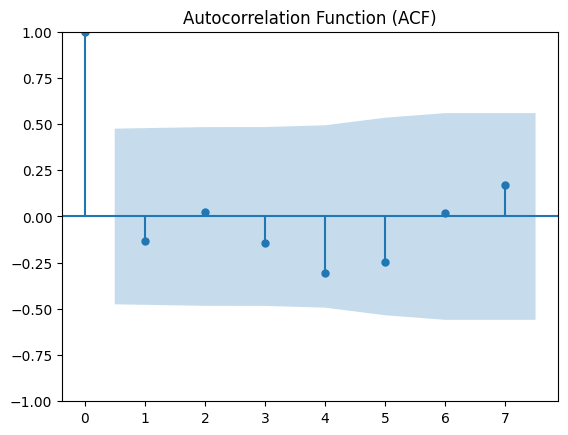

<Figure size 1200x600 with 0 Axes>

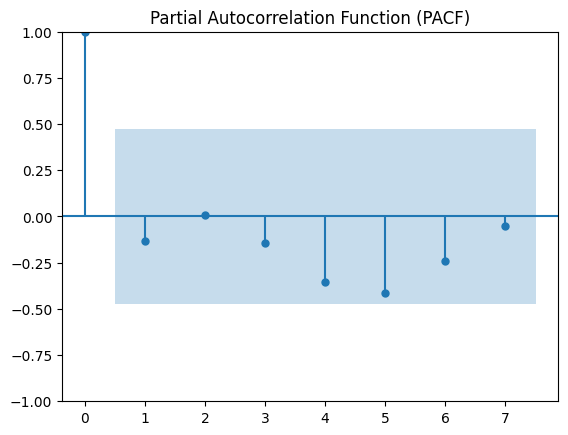


Fitting ARIMA model with order (4, 0, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   17
Model:                 ARIMA(4, 0, 1)   Log Likelihood                -125.692
Date:                Mon, 14 Apr 2025   AIC                            265.384
Time:                        14:45:22   BIC                            271.217
Sample:                             0   HQIC                           265.964
                                 - 17                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1611.7691     38.898     41.436      0.000    1535.531    1688.008
ar.L1          0.2669      0.31

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

Model for અજમાં uploaded to Spaces at ml_models/commodities_saved_models/arima_model_3e157308dc65450922103fc2ec9cb159.pkl
Model for અજમાં saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_3e157308dc65450922103fc2ec9cb159.pkl
કળથી size:  24
False
Checking stationarity for the raw price data of કળથી:

ADF Test Results:
ADF Statistic: -1.1466
p-value: 0.6961
Critical Value 1%: -3.9644
Critical Value 5%: -3.0849
Critical Value 10%: -2.6818
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -0.5115
p-value: 0.8898
Critical Value 1%: -3.9644
Critical Value 5%: -3.0849
Critical Value 10%: -2.6818
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -5.3114
p-value: 0.0000
Critical Value 1%: -3.9644
Critical Value 5%: -3.0849
Critical Value 10%: -2.6818
The series is stationary (no further differencing needed).
Data is stationary with d=2.

Checking stationarity for the differenced data:

<Figure size 1200x600 with 0 Axes>

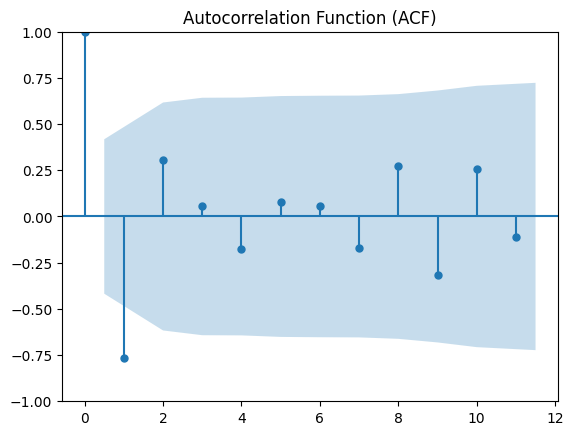

<Figure size 1200x600 with 0 Axes>

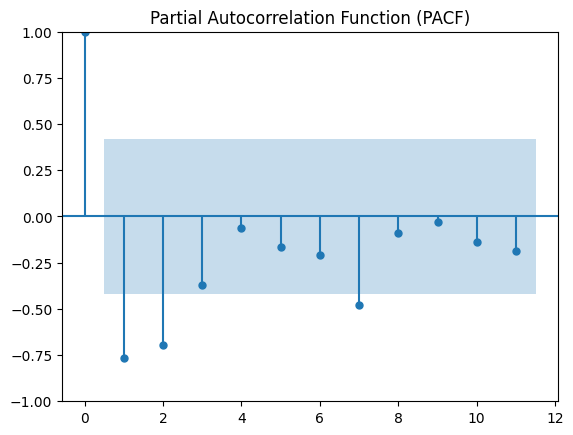


Fitting ARIMA model with order (5, 2, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   24
Model:                 ARIMA(5, 2, 1)   Log Likelihood                -147.273
Date:                Mon, 14 Apr 2025   AIC                            308.546
Time:                        14:45:24   BIC                            316.184
Sample:                             0   HQIC                           310.345
                                 - 24                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9223      0.277     -3.325      0.001      -1.466      -0.379
ar.L2         -0.3194      0.45

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for કળથી uploaded to Spaces at ml_models/commodities_saved_models/arima_model_99525a64369d30a26633ab7f717467df.pkl
Model for કળથી saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_99525a64369d30a26633ab7f717467df.pkl
ગોગળી size:  74
False
Checking stationarity for the raw price data of ગોગળી:

ADF Test Results:
ADF Statistic: -2.2865
p-value: 0.1764
Critical Value 1%: -3.5260
Critical Value 5%: -2.9032
Critical Value 10%: -2.5890
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -10.7557
p-value: 0.0000
Critical Value 1%: -3.5260
Critical Value 5%: -2.9032
Critical Value 10%: -2.5890
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -10.7557
p-value: 0.0000
Critical Value 1%: -3.5260
Critical Value 5%: -2.9032
Critical Value 10%: -2.5890
The series is stationary (no further differencing need

<Figure size 1200x600 with 0 Axes>

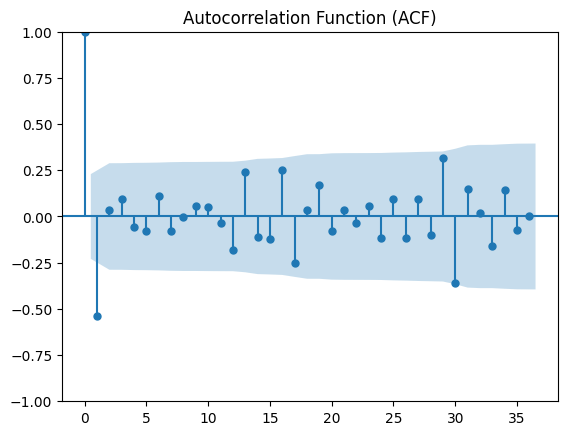

<Figure size 1200x600 with 0 Axes>

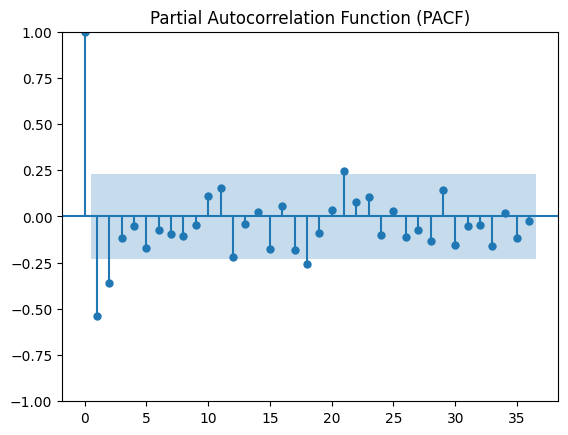


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   74
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -383.928
Date:                Mon, 14 Apr 2025   AIC                            781.855
Time:                        14:45:27   BIC                            797.889
Sample:                             0   HQIC                           788.245
                                 - 74                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4953      0.229     -2.163      0.031      -0.944      -0.046
ar.L2         -0.8300      0.262     -3.172      0.002      -1.343      -0.3

<Figure size 1200x600 with 0 Axes>

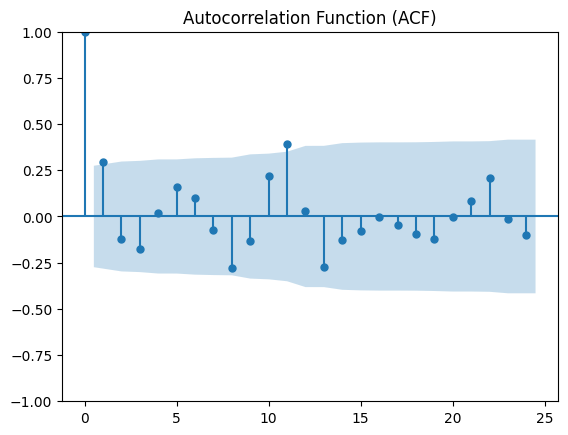

<Figure size 1200x600 with 0 Axes>

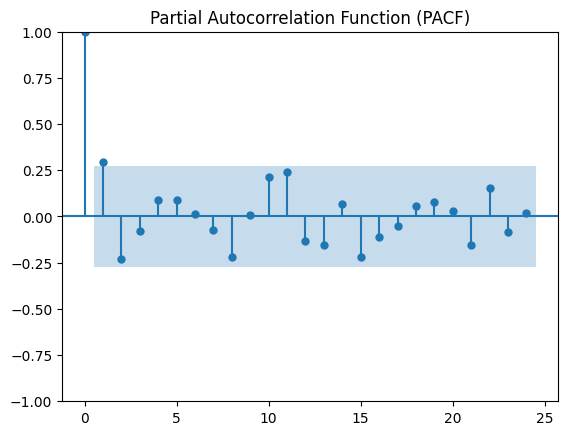


Fitting ARIMA model with order (3, 0, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   51
Model:                 ARIMA(3, 0, 3)   Log Likelihood                -395.742
Date:                Mon, 14 Apr 2025   AIC                            807.485
Time:                        14:45:31   BIC                            822.940
Sample:                             0   HQIC                           813.391
                                 - 51                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1442.4045    106.947     13.487      0.000    1232.791    1652.018
ar.L1          1.3382      0.297      4.511      0.000       0.757       1.9

<Figure size 1200x600 with 0 Axes>

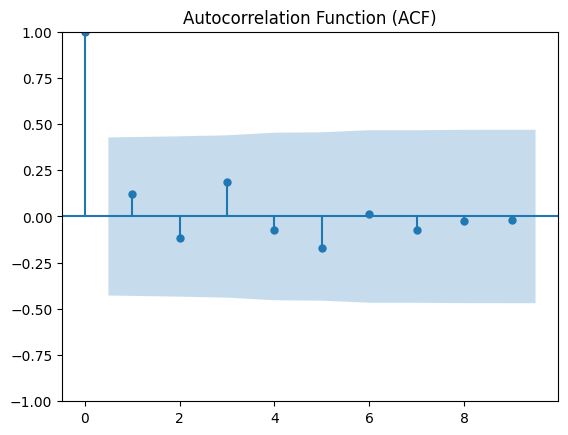

<Figure size 1200x600 with 0 Axes>

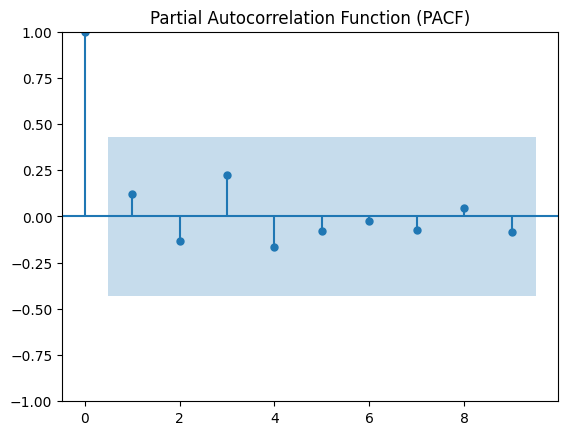


Fitting ARIMA model with order (0, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   21
Model:                          ARIMA   Log Likelihood                -166.870
Date:                Mon, 14 Apr 2025   AIC                            337.739
Time:                        14:45:34   BIC                            339.828
Sample:                             0   HQIC                           338.193
                                 - 21                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4207.9523    214.630     19.606      0.000    3787.284    4628.620
sigma2      4.673e+05   1.94e+0

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for તલ કાળા uploaded to Spaces at ml_models/commodities_saved_models/arima_model_49f80fa7c6dd53431dd17dcb30e646ae.pkl
Model for તલ કાળા saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_49f80fa7c6dd53431dd17dcb30e646ae.pkl
રાય size:  56
False
Checking stationarity for the raw price data of રાય:

ADF Test Results:
ADF Statistic: -4.1505
p-value: 0.0008
Critical Value 1%: -3.5553
Critical Value 5%: -2.9157
Critical Value 10%: -2.5957
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -4.1505
p-value: 0.0008
Critical Value 1%: -3.5553
Critical Value 5%: -2.9157
Critical Value 10%: -2.5957
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 0 at lags []
Significant spikes in PACF (p): 2 at lags [11 14]


<Figure size 1200x600 with 0 Axes>

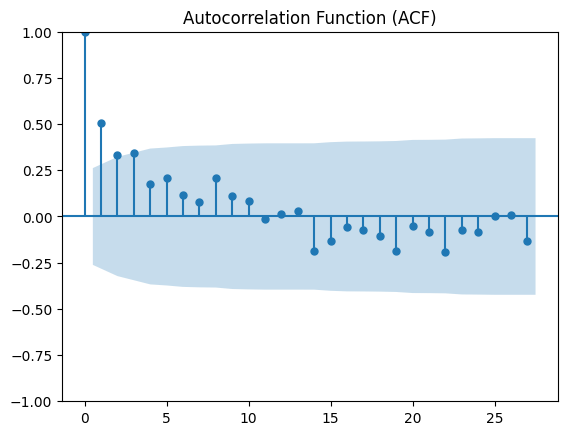

<Figure size 1200x600 with 0 Axes>

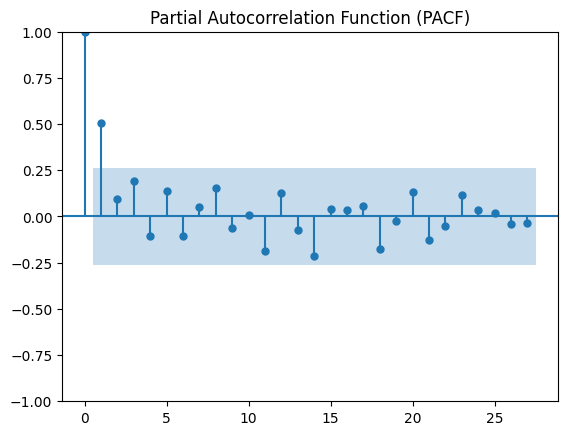


Fitting ARIMA model with order (2, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   56
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -326.437
Date:                Mon, 14 Apr 2025   AIC                            660.873
Time:                        14:45:36   BIC                            668.975
Sample:                             0   HQIC                           664.014
                                 - 56                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1068.0314     24.865     42.953      0.000    1019.297    1116.766
ar.L1          0.4533      0.16

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for રાય uploaded to Spaces at ml_models/commodities_saved_models/arima_model_af87db7c4e2153de48f7a2d1ab4dfeba.pkl
Model for રાય saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_af87db7c4e2153de48f7a2d1ab4dfeba.pkl
મરચા સૂકા પટ્ટો size:  27
False
Checking stationarity for the raw price data of મરચા સૂકા પટ્ટો:

ADF Test Results:
ADF Statistic: -1.8701
p-value: 0.3463
Critical Value 1%: -3.7112
Critical Value 5%: -2.9812
Critical Value 10%: -2.6301
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -1.3904
p-value: 0.5869
Critical Value 1%: -3.7884
Critical Value 5%: -3.0131
Critical Value 10%: -2.6464
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -5.2712
p-value: 0.0000
Critical Value 1%: -3.7884
Critical Value 5%: -3.0131
Critical Value 10%: -2.6464
The series is stationary (no further differencing needed).
Data is stationary with d=2.

Checking stationarity for the

<Figure size 1200x600 with 0 Axes>

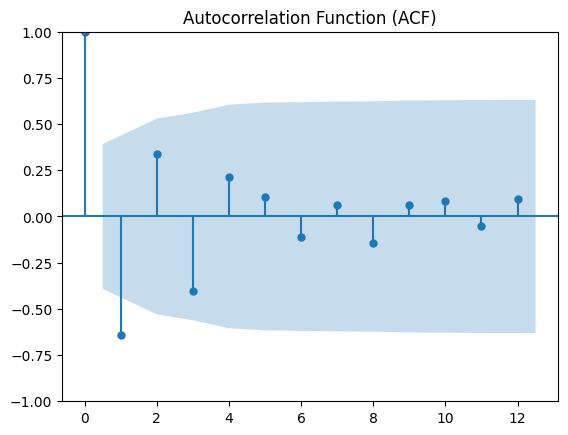

<Figure size 1200x600 with 0 Axes>

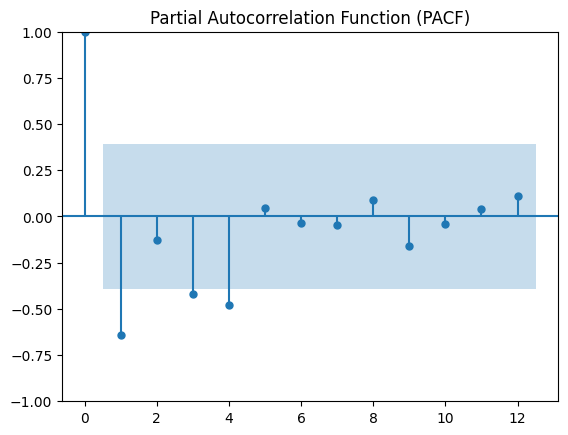


Fitting ARIMA model with order (2, 2, 2)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   27
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -203.870
Date:                Mon, 14 Apr 2025   AIC                            417.741
Time:                        14:45:38   BIC                            423.835
Sample:                             0   HQIC                           419.431
                                 - 27                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6050      1.580     -0.383      0.702      -3.702       2.492
ar.L2          0.0492      0.62

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for મરચા સૂકા પટ્ટો uploaded to Spaces at ml_models/commodities_saved_models/arima_model_f96e9f31f7dbe8f11fd09548b03ac684.pkl
Model for મરચા સૂકા પટ્ટો saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_f96e9f31f7dbe8f11fd09548b03ac684.pkl
ગુવાર બી size:  9
False
Checking stationarity for the raw price data of ગુવાર બી:

ADF Test Results:
ADF Statistic: -1.9412
p-value: 0.3129
Critical Value 1%: -4.6652
Critical Value 5%: -3.3672
Critical Value 10%: -2.8030
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -3.5736
p-value: 0.0063
Critical Value 1%: -4.9387
Critical Value 5%: -3.4776
Critical Value 10%: -2.8439
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -3.5736
p-value: 0.0063
Critical Value 1%: -4.9387
Critical Value 5%: -3.4776
Critical Value 10%: -2.8439
The series is stationary (no 

<Figure size 1200x600 with 0 Axes>

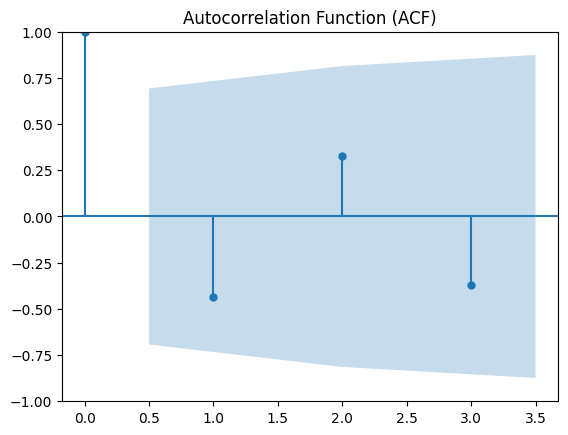

<Figure size 1200x600 with 0 Axes>

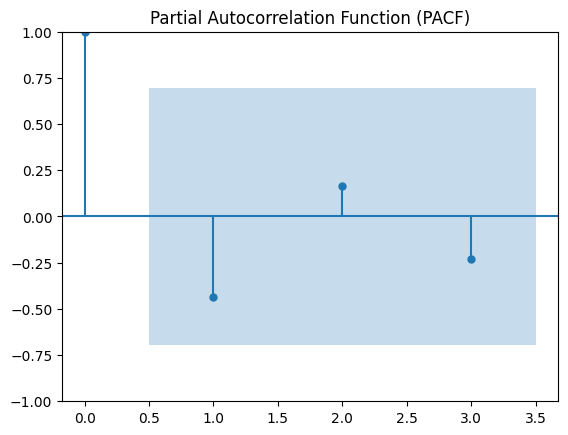


Fitting ARIMA model with order (2, 1, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                    9
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 -50.825
Date:                Mon, 14 Apr 2025   AIC                            109.651
Time:                        14:45:40   BIC                            109.968
Sample:                             0   HQIC                           107.507
                                  - 9                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5662      2.660     -0.213      0.831      -5.780       4.648
ar.L2          0.1489      1.88

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

Model for ગુવાર બી uploaded to Spaces at ml_models/commodities_saved_models/arima_model_b3efe0dd5d26617ba59a43460887cc2e.pkl
Model for ગુવાર બી saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_b3efe0dd5d26617ba59a43460887cc2e.pkl
રાયડો size:  45
False
Checking stationarity for the raw price data of રાયડો:

ADF Test Results:
ADF Statistic: -2.6035
p-value: 0.0923
Critical Value 1%: -3.5966
Critical Value 5%: -2.9333
Critical Value 10%: -2.6050
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -8.2483
p-value: 0.0000
Critical Value 1%: -3.5966
Critical Value 5%: -2.9333
Critical Value 10%: -2.6050
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -8.2483
p-value: 0.0000
Critical Value 1%: -3.5966
Critical Value 5%: -2.9333
Critical Value 10%: -2.6050
The series is stationary (no further differencin

<Figure size 1200x600 with 0 Axes>

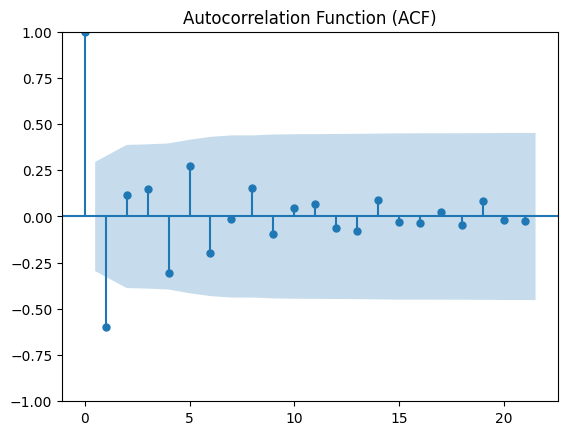

<Figure size 1200x600 with 0 Axes>

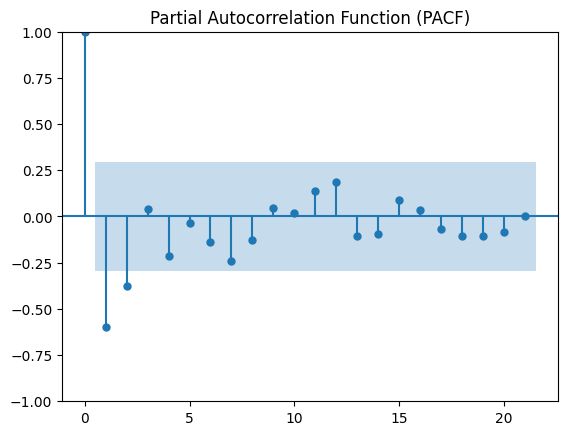


Fitting ARIMA model with order (2, 1, 2)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   45
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -274.603
Date:                Mon, 14 Apr 2025   AIC                            559.206
Time:                        14:45:42   BIC                            568.127
Sample:                             0   HQIC                           562.515
                                 - 45                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0937      0.252     -4.339      0.000      -1.588      -0.600
ar.L2         -0.1923      0.24

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for રાયડો uploaded to Spaces at ml_models/commodities_saved_models/arima_model_da7c8e19318dc530ec95d09294d2d0fb.pkl
Model for રાયડો saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_da7c8e19318dc530ec95d09294d2d0fb.pkl
અરીઠા size:  2
ક્લંજી size:  23
False
Checking stationarity for the raw price data of ક્લંજી:

ADF Test Results:
ADF Statistic: -1.3171
p-value: 0.6213
Critical Value 1%: -4.0689
Critical Value 5%: -3.1271
Critical Value 10%: -2.7017
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -1.1304
p-value: 0.7028
Critical Value 1%: -4.0689
Critical Value 5%: -3.1271
Critical Value 10%: -2.7017
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -2.8804
p-value: 0.0477
Critical Value 1%: -4.0120
Critical Value 5%: -3.1042
Critical Value 10%: -2.6910
The series is stationary (no further differencing needed).
Data is stationary with d=2.

Checking stationarity for th

<Figure size 1200x600 with 0 Axes>

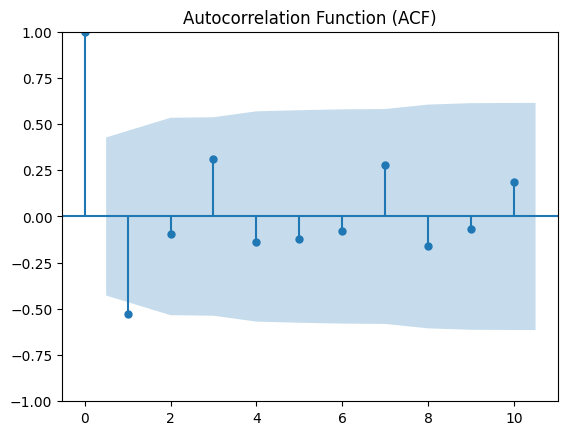

<Figure size 1200x600 with 0 Axes>

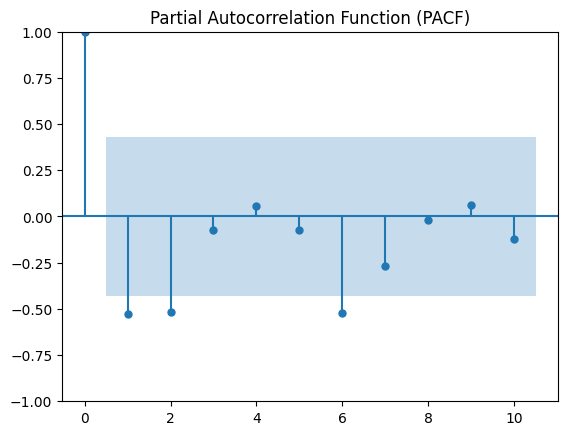


Fitting ARIMA model with order (4, 2, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   23
Model:                 ARIMA(4, 2, 1)   Log Likelihood                -148.148
Date:                Mon, 14 Apr 2025   AIC                            308.296
Time:                        14:45:45   BIC                            314.563
Sample:                             0   HQIC                           309.656
                                 - 23                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0063      0.308     -0.020      0.984      -0.610       0.598
ar.L2          0.0148      0.34

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for ક્લંજી uploaded to Spaces at ml_models/commodities_saved_models/arima_model_0e59e7efcba2b8d4f15c49aea2a2949d.pkl
Model for ક્લંજી saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_0e59e7efcba2b8d4f15c49aea2a2949d.pkl
સિંગદાણા જાડા size:  10
False
Checking stationarity for the raw price data of સિંગદાણા જાડા:

ADF Test Results:
ADF Statistic: -16.1685
p-value: 0.0000
Critical Value 1%: -5.3543
Critical Value 5%: -3.6462
Critical Value 10%: -2.9012
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -16.1685
p-value: 0.0000
Critical Value 1%: -5.3543
Critical Value 5%: -3.6462
Critical Value 10%: -2.9012
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 1 at lags [2]
Significant spikes in PACF (p): 1 at lags [2]


<Figure size 1200x600 with 0 Axes>

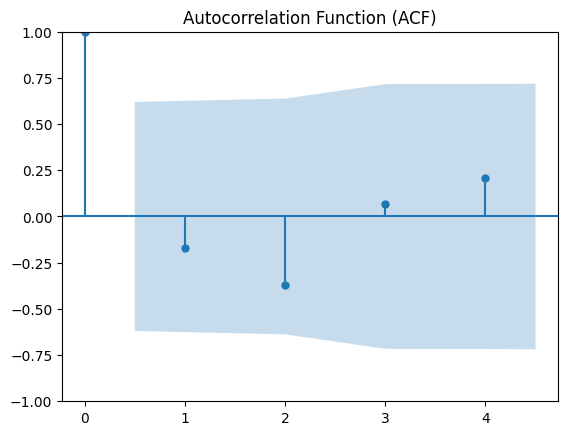

<Figure size 1200x600 with 0 Axes>

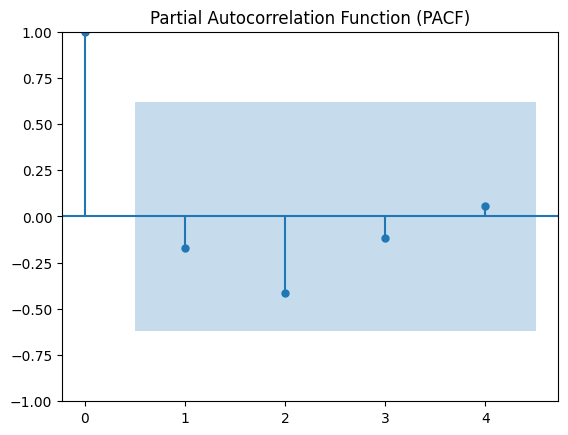


Fitting ARIMA model with order (1, 0, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   10
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -57.259
Date:                Mon, 14 Apr 2025   AIC                            122.518
Time:                        14:45:48   BIC                            123.728
Sample:                             0   HQIC                           121.190
                                 - 10                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1214.0903     30.728     39.511      0.000    1153.865    1274.316
ar.L1          0.3975      0.58

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for સિંગદાણા જાડા uploaded to Spaces at ml_models/commodities_saved_models/arima_model_632b35643e54bca06e234a9192ba0e79.pkl
Model for સિંગદાણા જાડા saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_632b35643e54bca06e234a9192ba0e79.pkl
તલ લાલ size:  10
True
Checking stationarity for the raw price data of તલ લાલ:

ADF Test Results:
ADF Statistic: -2.3141
p-value: 0.1675
Critical Value 1%: -4.4731
Critical Value 5%: -3.2899
Critical Value 10%: -2.7724
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -4.3502
p-value: 0.0004
Critical Value 1%: -4.6652
Critical Value 5%: -3.3672
Critical Value 10%: -2.8030
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -4.3502
p-value: 0.0004
Critical Value 1%: -4.6652
Critical Value 5%: -3.3672
Critical Value 10%: -2.8030
The series is stationary (no further 

<Figure size 1200x600 with 0 Axes>

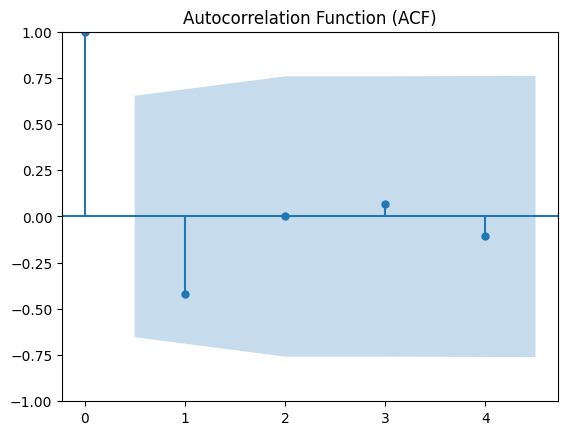

<Figure size 1200x600 with 0 Axes>

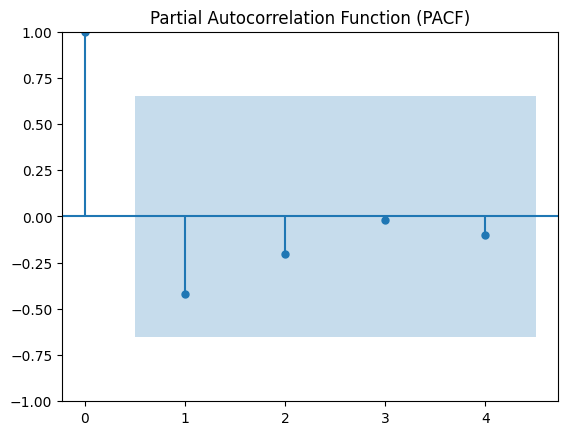


Fitting ARIMA model with order (1, 1, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   10
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -63.333
Date:                Mon, 14 Apr 2025   AIC                            132.665
Time:                        14:45:50   BIC                            133.257
Sample:                             0   HQIC                           131.388
                                 - 10                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7036      0.463     -1.519      0.129      -1.611       0.204
ma.L1          0.0793      1.00

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for તલ લાલ uploaded to Spaces at ml_models/commodities_saved_models/arima_model_c31181ab0610a68a7920f6ed42dca1ec.pkl
Model for તલ લાલ saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_c31181ab0610a68a7920f6ed42dca1ec.pkl
નવા ધાણા size:  24
True
Checking stationarity for the raw price data of નવા ધાણા:

ADF Test Results:
ADF Statistic: -1.8306
p-value: 0.3654
Critical Value 1%: -3.9240
Critical Value 5%: -3.0685
Critical Value 10%: -2.6739
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: 4.0626
p-value: 1.0000
Critical Value 1%: -4.0689
Critical Value 5%: -3.1271
Critical Value 10%: -2.7017
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: 0.4997
p-value: 0.9849
Critical Value 1%: -4.1378
Critical Value 5%: -3.1550
Critical Value 10%: -2.7145
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -5.1947
p-value: 0.0000
Critical Value

<Figure size 1200x600 with 0 Axes>

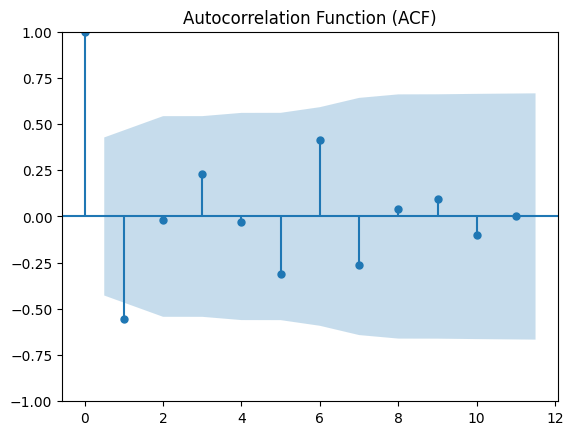

Can't plot the acf/pacf plots for નવા ધાણા due to Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 11 must be < 10.

Fitting ARIMA model with order (3, 3, 2)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   24
Model:                 ARIMA(3, 3, 2)   Log Likelihood                -163.805
Date:                Mon, 14 Apr 2025   AIC                            339.609
Time:                        14:45:52   BIC                            345.877
Sample:                             0   HQIC                           340.970
                                 - 24                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for નવા ધાણા uploaded to Spaces at ml_models/commodities_saved_models/arima_model_3b745a66181ed9d2981ad74a5c832c61.pkl
Model for નવા ધાણા saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_3b745a66181ed9d2981ad74a5c832c61.pkl
રજકાનું બી size:  7
True
Checking stationarity for the raw price data of રજકાનું બી:

ADF Test Results:
ADF Statistic: -1.6227
p-value: 0.4713
Critical Value 1%: -5.3543
Critical Value 5%: -3.6462
Critical Value 10%: -2.9012
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -2.7336
p-value: 0.0684
Critical Value 1%: -7.3554
Critical Value 5%: -4.4744
Critical Value 10%: -3.1269
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -1.9970
p-value: 0.2879
Critical Value 1%: -7.3554
Critical Value 5%: -4.4744
Critical Value 10%: -3.1269
The series is not stationary (differencing is required).
Data is stationary with d=3.

Checking stationarity for the dif

<Figure size 1200x600 with 0 Axes>

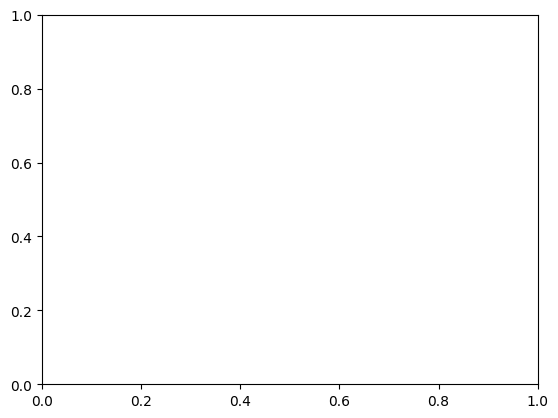

<Figure size 1200x600 with 0 Axes>

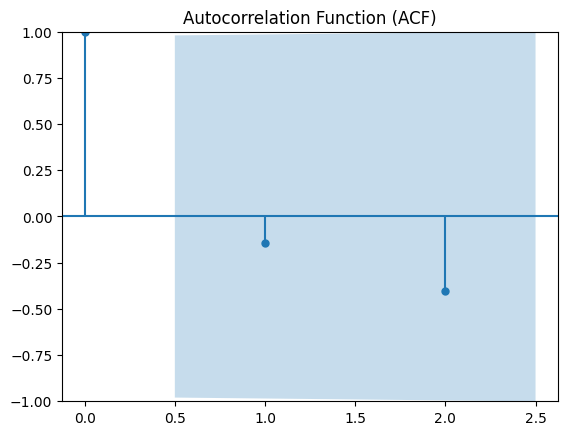

<Figure size 1200x600 with 0 Axes>

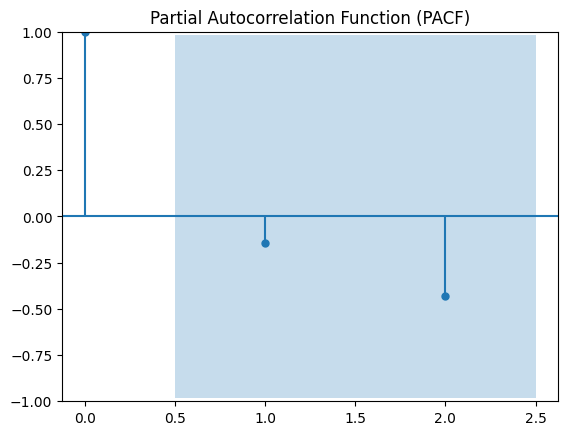


Fitting ARIMA model with order (0, 3, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                    7
Model:                 ARIMA(0, 3, 0)   Log Likelihood                 -33.501
Date:                Mon, 14 Apr 2025   AIC                             69.003
Time:                        14:45:55   BIC                             68.389
Sample:                             0   HQIC                            67.656
                                  - 7                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.099e+06   8.95e+05      1.228      0.219   -6.55e+05    2.85e+06
Ljung-Box (L1) (Q):            

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

Model for રજકાનું બી uploaded to Spaces at ml_models/commodities_saved_models/arima_model_7d8513c1ad648bbae8e3d458f23ad8da.pkl
Model for રજકાનું બી saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_7d8513c1ad648bbae8e3d458f23ad8da.pkl
નવી ધાણી size:  24
False
Checking stationarity for the raw price data of નવી ધાણી:

ADF Test Results:
ADF Statistic: -4.5731
p-value: 0.0001
Critical Value 1%: -3.7697
Critical Value 5%: -3.0054
Critical Value 10%: -2.6425
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -4.5731
p-value: 0.0001
Critical Value 1%: -3.7697
Critical Value 5%: -3.0054
Critical Value 10%: -2.6425
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 2 at lags [2 9]
Significant spikes in PACF (p): 4 at lags [ 2  6  8 10]


<Figure size 1200x600 with 0 Axes>

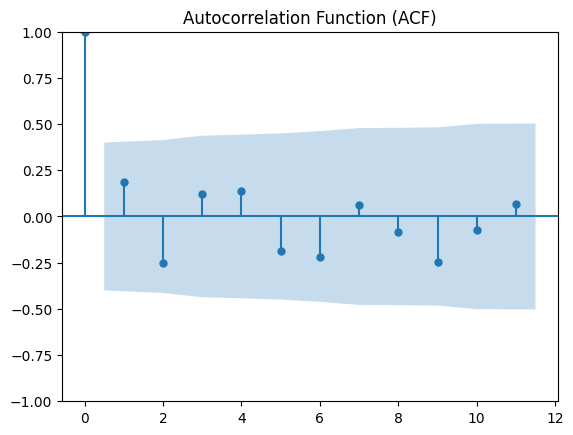

<Figure size 1200x600 with 0 Axes>

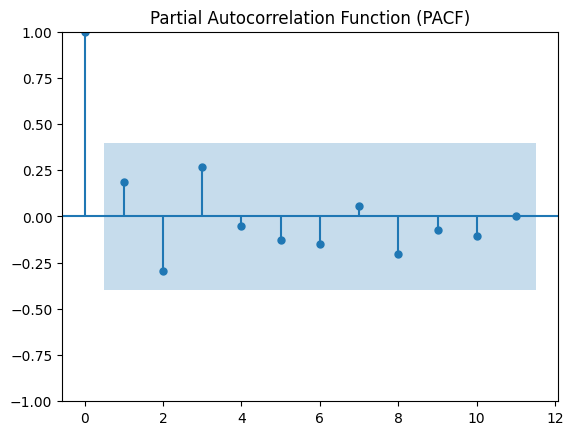


Fitting ARIMA model with order (4, 0, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   24
Model:                 ARIMA(4, 0, 2)   Log Likelihood                -174.034
Date:                Mon, 14 Apr 2025   AIC                            364.069
Time:                        14:45:57   BIC                            373.493
Sample:                             0   HQIC                           366.569
                                 - 24                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2290.9421    117.044     19.573      0.000    2061.540    2520.344
ar.L1          0.7153      0.299      2.391      0.017       0.129       1.3

<Figure size 1200x600 with 0 Axes>

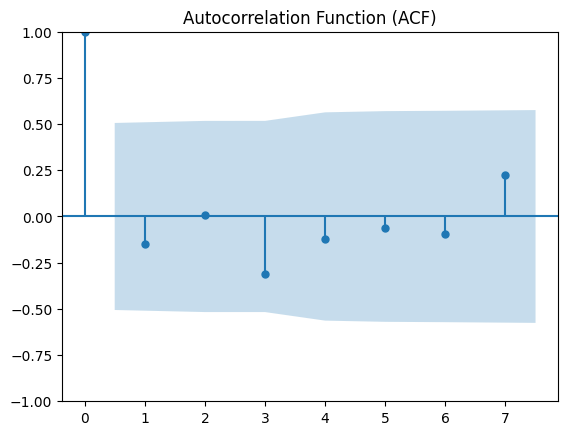

<Figure size 1200x600 with 0 Axes>

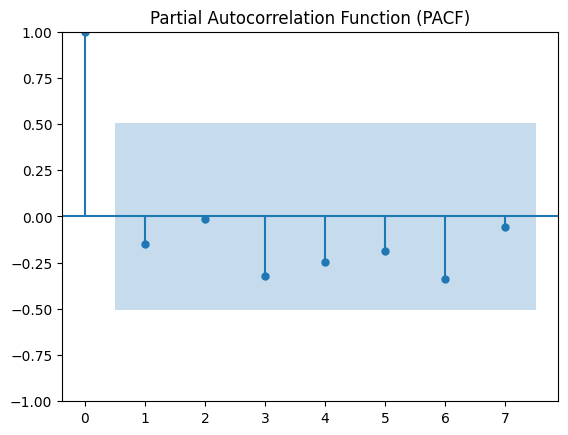


Fitting ARIMA model with order (4, 1, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   16
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -106.327
Date:                Mon, 14 Apr 2025   AIC                            224.654
Time:                        14:46:00   BIC                            228.903
Sample:                             0   HQIC                           224.609
                                 - 16                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3351      1.693      0.198      0.843      -2.984       3.654
ar.L2          0.0484      0.58

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for સુરજમુખી uploaded to Spaces at ml_models/commodities_saved_models/arima_model_bfa8c61fcee8cd29cbcc5312e445c5ff.pkl
Model for સુરજમુખી saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_bfa8c61fcee8cd29cbcc5312e445c5ff.pkl
નવું લસણ size:  24
True
Checking stationarity for the raw price data of નવું લસણ:

ADF Test Results:
ADF Statistic: -2.1578
p-value: 0.2219
Critical Value 1%: -4.0120
Critical Value 5%: -3.1042
Critical Value 10%: -2.6910
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -13.3551
p-value: 0.0000
Critical Value 1%: -3.7697
Critical Value 5%: -3.0054
Critical Value 10%: -2.6425
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -13.3551
p-value: 0.0000
Critical Value 1%: -3.7697
Critical Value 5%: -3.0054
Critical Value 10%: -2.6425
The series is stationary (no further diff

<Figure size 1200x600 with 0 Axes>

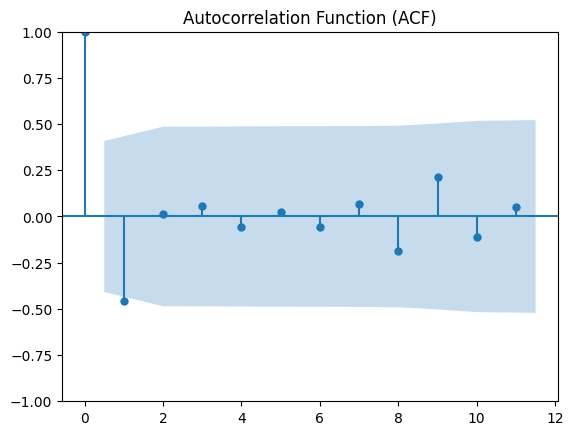

<Figure size 1200x600 with 0 Axes>

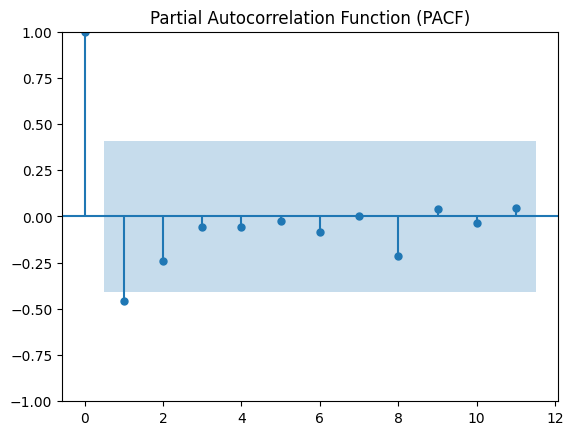


Fitting ARIMA model with order (3, 1, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   24
Model:                 ARIMA(3, 1, 1)   Log Likelihood                   0.000
Date:                Mon, 14 Apr 2025   AIC                             10.000
Time:                        14:46:02   BIC                             15.677
Sample:                             0   HQIC                            11.428
                                 - 24                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000   6.28e-07  -1.59e+06      0.000      -1.000      -1.000
ar.L2          1.0000        na

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

Model for નવું લસણ uploaded to Spaces at ml_models/commodities_saved_models/arima_model_fd8740eeef51975fce673af58100e1dc.pkl
Model for નવું લસણ saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_fd8740eeef51975fce673af58100e1dc.pkl
નવું જીરૂ size:  17
True
Checking stationarity for the raw price data of નવું જીરૂ:
Stationarity cannot be applicable for નવું જીરૂ
Significant spikes in ACF (q): 0 at lags []
Significant spikes in PACF (p): 0 at lags []


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1490: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


<Figure size 1200x600 with 0 Axes>

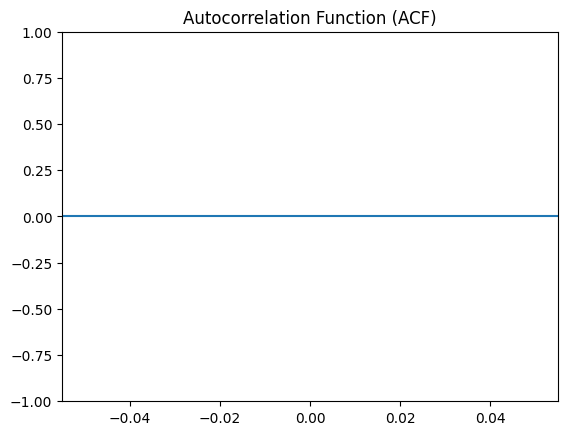

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1490: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)


<Figure size 1200x600 with 0 Axes>

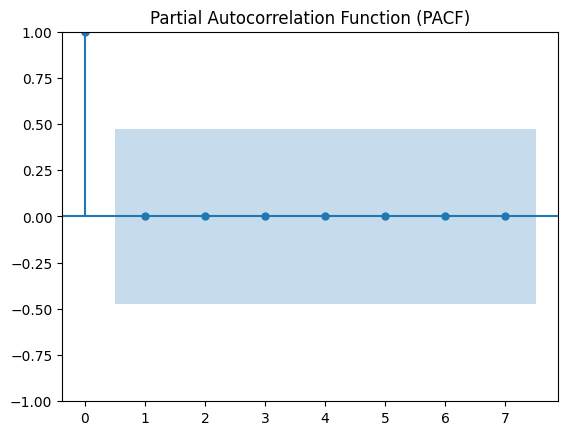

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)



Fitting ARIMA model with order (0, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   17
Model:                          ARIMA   Log Likelihood                -165.003
Date:                Mon, 14 Apr 2025   AIC                            334.005
Time:                        14:46:04   BIC                            335.672
Sample:                             0   HQIC                           334.171
                                 - 17                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5129.2353    1.8e+04      0.284      0.776   -3.02e+04    4.05e+04
sigma2      1.574e+07   3.82e+0

<Figure size 1200x600 with 0 Axes>

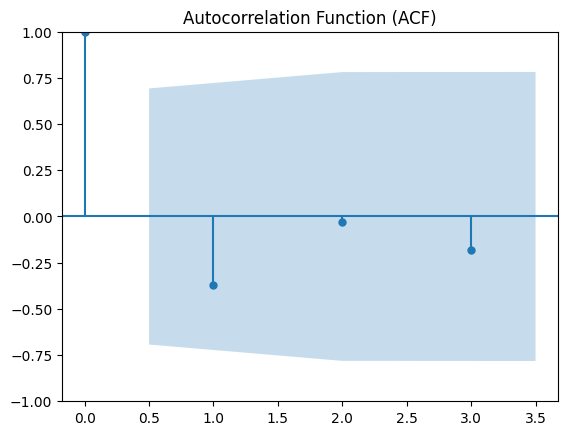

<Figure size 1200x600 with 0 Axes>

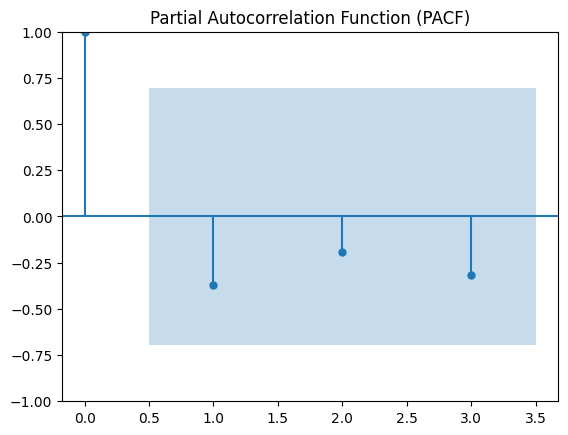


Fitting ARIMA model with order (2, 1, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                    9
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 -56.352
Date:                Mon, 14 Apr 2025   AIC                            120.705
Time:                        14:46:06   BIC                            121.023
Sample:                             0   HQIC                           118.562
                                  - 9                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1432      4.965      0.029      0.977      -9.588       9.874
ar.L2         -0.3109      2.34

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

Model for સુવાદાણા uploaded to Spaces at ml_models/commodities_saved_models/arima_model_aa5a27e7fa2e0ddc4d6438cf6ce4afc4.pkl
Model for સુવાદાણા saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_aa5a27e7fa2e0ddc4d6438cf6ce4afc4.pkl
વાલ પાપડી size:  5
False
Checking stationarity for the raw price data of વાલ પાપડી:

ADF Test Results:
ADF Statistic: -5.4706
p-value: 0.0000
Critical Value 1%: -7.3554
Critical Value 5%: -4.4744
Critical Value 10%: -3.1269
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -5.4706
p-value: 0.0000
Critical Value 1%: -7.3554
Critical Value 5%: -4.4744
Critical Value 10%: -3.1269
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 0 at lags []
Significant spikes in PACF (p): 0 at lags []


<Figure size 1200x600 with 0 Axes>

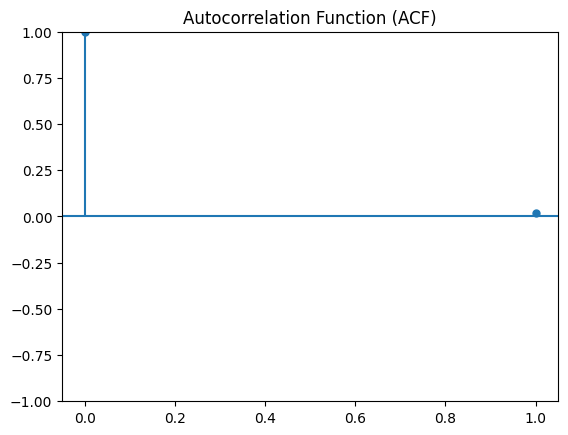

<Figure size 1200x600 with 0 Axes>

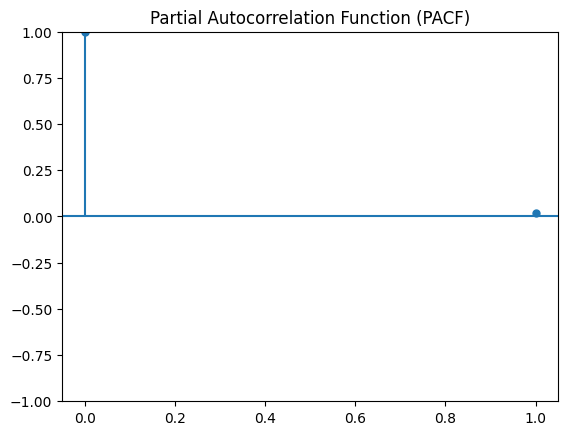


Fitting ARIMA model with order (0, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                    5
Model:                          ARIMA   Log Likelihood                 -36.509
Date:                Mon, 14 Apr 2025   AIC                             77.017
Time:                        14:46:08   BIC                             76.236
Sample:                             0   HQIC                            74.921
                                  - 5                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1248.0000    401.320      3.110      0.002     461.427    2034.573
sigma2      1.283e+05   2.04e+0

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for વાલ પાપડી uploaded to Spaces at ml_models/commodities_saved_models/arima_model_abb4268fbaab1f48417b77896ce2d084.pkl
Model for વાલ પાપડી saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_abb4268fbaab1f48417b77896ce2d084.pkl
કારીજીરી size:  3
નવા ચણા size:  1
ઘઉં નવા size:  1
મરચા સૂકા ઘોલર size:  7
True
Checking stationarity for the raw price data of મરચા સૂકા ઘોલર:

ADF Test Results:
ADF Statistic: -0.8328
p-value: 0.8093
Critical Value 1%: -5.3543
Critical Value 5%: -3.6462
Critical Value 10%: -2.9012
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -2.6104
p-value: 0.0909
Critical Value 1%: -7.3554
Critical Value 5%: -4.4744
Critical Value 10%: -3.1269
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -3.4319
p-value: 0.0099
Critical Value 1%: -7.3554
Critical Value 5%: -4.4744
Critical Value 10%: -3.1269
The series is stationary (no further differencing needed).

<Figure size 1200x600 with 0 Axes>

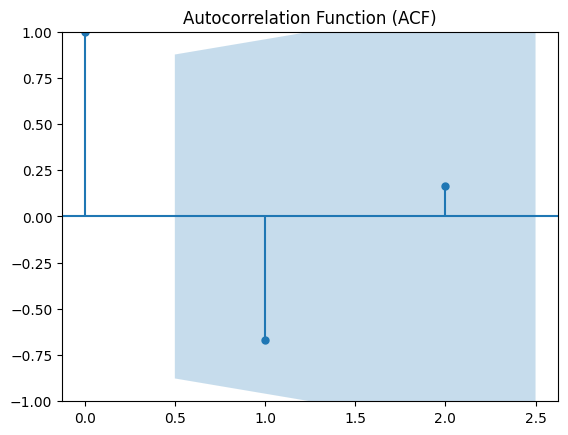

<Figure size 1200x600 with 0 Axes>

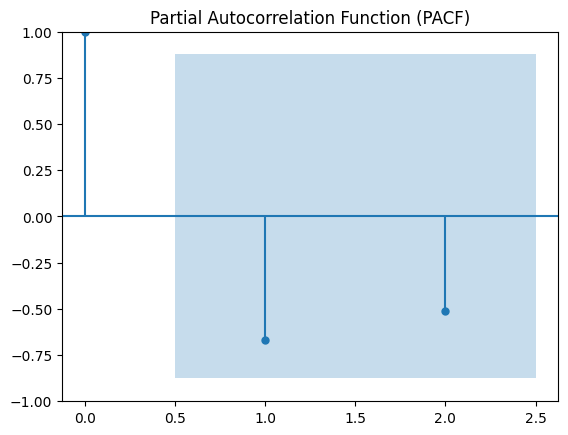


Fitting ARIMA model with order (1, 2, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                    7
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -177.940
Date:                Mon, 14 Apr 2025   AIC                            361.881
Time:                        14:46:10   BIC                            360.709
Sample:                             0   HQIC                           358.736
                                  - 7                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3800      0.012    -32.331      0.000      -0.403      -0.357
ma.L1         -0.9995      0.00

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

Model for મરચા સૂકા ઘોલર uploaded to Spaces at ml_models/commodities_saved_models/arima_model_8fcdf6a66b43ebe08ac56b000190e32f.pkl
Model for મરચા સૂકા ઘોલર saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_8fcdf6a66b43ebe08ac56b000190e32f.pkl


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
import csv
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from dateutil import rrule
from datetime import date
import time
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox, skew
from matplotlib import font_manager as fm
import os
import joblib
import hashlib
import csv
import boto3
import io
from dotenv import load_dotenv
load_dotenv()


###------------------------------------------------------------------------------------------------------------------------------
# Setup your DigitalOcean Spaces client
def get_spaces_client():
    return boto3.client(
        's3',
        region_name=os.getenv("SPACES_REGION"),
        endpoint_url=os.getenv("SPACES_ENDPOINT_URL"),
        aws_access_key_id=os.getenv("SPACES_ACCESS_KEY"),
        aws_secret_access_key=os.getenv("SPACES_SECRET_KEY")
    )

def dump_model_to_spaces(model, product, category):
    try:
        # Prepare filename
        hashed_name = safe_filename(product)
        filename = f"arima_model_{hashed_name}.pkl"
        key = f"ml_models/{category}/{filename}"  
        bucket = os.getenv("SPACES_BUCKET_NAME")
        print(f"Uploading to bucket: {bucket} with key: {key}")

        # Serialize model to bytes
        bytes_buffer = io.BytesIO()
        joblib.dump(model, bytes_buffer)
        bytes_buffer.seek(0)

        # Upload to Spaces
        client = get_spaces_client()
        client.put_object(Bucket=os.getenv("SPACES_BUCKET_NAME"), Key=key, Body=bytes_buffer)

        print(f"Model for {product} uploaded to Spaces at {key}")
    except Exception as e:
        print(f"Error uploading model for {product} to Spaces: {e}")
        

def filterData(existing_data):
    data = existing_data
    
    # Get current date and calculate the cutoff date (4 months ago)
    current_date = datetime.today()
    cutoff_date = current_date - timedelta(days=4*30) # Approximate 4 months
    cutoff_date = cutoff_date.replace(hour=0, minute=0, second=0, microsecond=0)

    # today_date = datetime.now().strftime("%d/%m/%Y")

    # Filter data to keep only the last 4 months
    filtered_data = data[pd.to_datetime(data["Date"], dayfirst=True) >= cutoff_date]
    print(f"Data older than {cutoff_date.strftime('%d-%m-%Y')} has been removed.")
    
    return filtered_data


def append_csv_to_spaces(new_df: pd.DataFrame, filename: str):
    client = get_spaces_client()
    key = f"data/commodities/{filename}"

    try:
        # Step 1: Download existing file if it exists
        existing = client.get_object(Bucket=os.getenv("SPACES_BUCKET_NAME"), Key=key)
        existing_data = pd.read_csv(existing['Body'])
        print("📥 Existing CSV loaded from Spaces.")
        
        if(filename == "commodities_price_data.csv"):
            existing_data = filterData(existing_data)
            

        # Step 2: Append new data
        combined_df = pd.concat([existing_data, new_df], ignore_index=True)

    except client.exceptions.NoSuchKey:
        print("ℹ️ No existing file found. Creating a new one.")
        combined_df = new_df

    # Step 3: Upload updated CSV
    csv_buffer = io.StringIO()
    combined_df.to_csv(csv_buffer, index=False)
    csv_buffer.seek(0)

    client.put_object(Bucket=os.getenv("SPACES_BUCKET_NAME"), Key=key, Body=csv_buffer.getvalue())

    print(f"✅ CSV saved to Spaces at {key}")



products_with_boxcox = []
### removes data older than 4 months-----------------------------------------------------------------------------------------------
base_dir = Path(os.getenv("BASE_DIRECTORY"))
file_path = base_dir / "data/commodities/commodities_price_data.csv"


# csv_file = "commodities_price_data.csv"  # Update with your file path
save_dir = base_dir / "ml_models/commodities_saved_models"
filename = base_dir / "ml_models/commodities_saved_models/vegetables_parameters.csv"
allYearsFilename = base_dir / "data/commodities/commodities_price_data-all_years.csv"
os.makedirs(save_dir, exist_ok=True)
data = pd.read_csv(file_path, encoding='utf-8', parse_dates=['Date'], date_format='%d/%m/%Y')
print(data.head())
products = data['Item Name'].unique()
print(products)

# Get current date and calculate the cutoff date (4 months ago)
current_date = datetime.today()
cutoff_date = current_date - timedelta(days=4*30) # Approximate 4 months
cutoff_date = cutoff_date.replace(hour=0, minute=0, second=0, microsecond=0)

today_date = datetime.now().strftime("%d/%m/%Y")

# Filter data to keep only the last 4 months
filtered_data = data[pd.to_datetime(data["Date"], dayfirst=True) >= cutoff_date]

# Save the cleaned data back to CSV
filtered_data.to_csv(file_path, encoding='utf-8', index=False)

print(f"Data older than {cutoff_date.strftime('%d-%m-%Y')} has been removed.")

logs = []
###------------------------------------------------------------------------------------------------------------------------------



###Saving updated ARIMA models---------------------------------------------------------------------------------------------------

# Step 1: Stationarity Check
def check_stationarity(series, size):
    if len(series) == size:
        return True
    result = adfuller(series)
    print("\nADF Test Results:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"Critical Value {key}: {value:.4f}")
    if result[1] < 0.05:
        print("The series is stationary (no further differencing needed).")
        return True
    else:
        print("The series is not stationary (differencing is required).")
        return False

# Function to count significant lags
def count_significant_spikes(values, confint):
    # The significant lags are those outside the confidence interval
    significant_lags = np.where(np.abs(values) > confint[:, 1])[0]
    return len(significant_lags), significant_lags

# Function to generate a safe file name
def safe_filename(product_name):
    return hashlib.md5(product_name.encode('utf-8')).hexdigest()





###updating the csv with current data---------------------------------------------------------------------------------------------

def write_to_csv(data, filename):
    # Define the field names for the CSV file
    # fieldnames = ['Serial Number', 'Date', 'Item Name', 'Low Price', 'Average Price', 'High Price']
    
    # Write data to CSV file
    with open(filename, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        
        # Write header row
        # writer.writerow(fieldnames)
        
        # Write data rows
        for _, row_data in enumerate(data):
            date = row_data[0]
            item_name = row_data[2]
            low_price = row_data[3]
            avg_price = row_data[5]
            high_price = row_data[4]
            writer.writerow([date, item_name, low_price, avg_price, high_price])
            
            
def getData(driver, csv_file_name, webpage_path, date_path, submit_button_path, table_path):
    
    # add_field_names_price(csv_file_name)
    
    #iterate over all the dates    
    try:
        # Open the webpage
        driver.get(webpage_path)
            
        # Find the date input element
        date_input = driver.find_element(By.XPATH, date_path)

        # Clear any existing text in the date input field
        date_input.clear()
          
        # Enter the desired date
        date_input.send_keys(current_date.strftime('%d-%m-%Y'))  # Example date, replace with your desired date

        # Find and click the button to get data for the specified date
        submit_button = driver.find_element(By.XPATH, submit_button_path)
        submit_button.click()
         
        time.sleep(3) #to load data

        #Extract the table data
        table = driver.find_element(By.XPATH, table_path)
        # print(table)
        data = []

        # Iterate over each row in the table
        for row in table.find_elements(By.TAG_NAME, "tr"):
            # Find all cells (td) in the row
            cells = row.find_elements(By.TAG_NAME, "td")
                
            # Ensure that there are cells in the row
            if cells:
                # Extract text from each cell and append to the data list
                row_data = [current_date.strftime('%d-%m-%Y')] + [cell.text.strip() for cell in cells]
                data.append(row_data)
        
        
        columns = ["Date", "Some Extra Column", "Item Name", "Low Price", "Average Price", "High Price"]
        new_df = pd.DataFrame(data, columns=columns)
        print("Before dropping the column:")
        print(new_df.head())
        

        # Drop the column at index 1 (which corresponds to "Item Name")
        new_df.drop(new_df.columns[1], axis=1, inplace=True)
        
        print("\nAfter dropping the column:")
        print(new_df.head())
        
        new_df['Average Price'], new_df['High Price'] = new_df['High Price'], new_df['Average Price']

        # Print the new DataFrame to verify
        print("\nAfter rearranging the column:")
        print(new_df.head())


        # Print the extracted data for debugging
        # for row in data:
        #     print(row)
        write_to_csv(data, csv_file_name)
        append_csv_to_spaces(new_df, "commodities_price_data.csv")
        write_to_csv(data, allYearsFilename)
        append_csv_to_spaces(new_df, "commodities_price_data-all_years.csv")
        time.sleep(2)
        # return data
            
    except Exception as e:
        print(e)
        pass


def main():
    # Initialize Chrome WebDriver
    driver = webdriver.Chrome()

    # commodities_data_table = 
    getData(driver, file_path, os.getenv("COMMODITIES_WEBPAGE_PATH"), 
                                             os.getenv("COMMODITIES_DATE_PATH"),
                                             os.getenv("COMMODITIES_SUBMIT_BUTTON_PATH"),
                                             os.getenv("COMMODITIES_TABLE_PATH"))
    
    time.sleep(5)
    
    # Close the WebDriver
    driver.quit()
    
    
    
    ###Updating models------------------------------------------------------------------------------------------------------------
    
    for product in products:
    
        product_name = product 
        product_data = data[data['Item Name'] == product_name]
        size_product_data = product_data.shape[0]
        print(product_name, "size: ", size_product_data)
        
        if((size_product_data//2)-1 <= 0):
            continue
        
        # Check if any data exists for the selected product
        if product_data.empty:
            print(f"No data found for the product: {product_name}")

        else:
            # Extract the 'Average Price' column for the selected product
            price_data = product_data['Average Price']
            
        variance_ratio = price_data.std() / price_data.mean()
        skewness = skew(price_data)

        if variance_ratio > 0.1 and skewness > 0.5:
            apply_boxcox = True
            products_with_boxcox.append(product_name)
        else:
            apply_boxcox = False
        
        
        print(apply_boxcox)
        # Step 2: Differencing (if necessary)
        print(f"Checking stationarity for the raw price data of {product_name}:")
        d = 0
        price_diff = price_data
        
        try:
            if apply_boxcox:
                price_diff, lam = boxcox(price_diff)
                price_diff = pd.Series(price_diff)
        
            while True:
                if check_stationarity(price_diff, (size_product_data//2)+1):
                    # price_diff = price_data
                    print(f"Data is stationary with d={d}.")
                    break
                else:
                    price_diff = price_diff.diff().dropna()
                    d += 1
        

            print("\nChecking stationarity for the differenced data:")
            check_stationarity(price_diff, (size_product_data//2)+1)
        
        except Exception as e:
            print(f"Stationarity cannot be applicable for {product_name}")
        
        
        # Step 3: Plot ACF and PACF

        acf_values, acf_confint = acf(price_diff, alpha=0.05)
        pacf_values, pacf_confint = pacf(price_diff, alpha=0.05)


        # Count significant spikes for ACF (q)
        q, significant_acf_lags = count_significant_spikes(acf_values, acf_confint)

        # Count significant spikes for PACF (p)
        p, significant_pacf_lags = count_significant_spikes(pacf_values, pacf_confint)

        print(f"Significant spikes in ACF (q): {q} at lags {significant_acf_lags}")
        print(f"Significant spikes in PACF (p): {p} at lags {significant_pacf_lags}")

        # ACF and PACF Plots
        try:
            plt.figure(figsize=(12, 6))
            plot_acf(price_diff, lags=(size_product_data//2)-1, title="Autocorrelation Function (ACF)")
            plt.show()

            plt.figure(figsize=(12, 6))
            plot_pacf(price_diff, lags=(size_product_data//2)-1, title="Partial Autocorrelation Function (PACF)")
            plt.show()
        
        except Exception as e:
            print(f"Can't plot the acf/pacf plots for {product_name} due to {e}")
        
        if p > 5:
            p = min(5, q)
        if q > 5: 
            q = min(5, p)
        if d > 3:
            d = 1

        fit_successful = False

        while not fit_successful and q >= 0:
            try:
                print(f"\nFitting ARIMA model with order ({p}, {d}, {q})...")
                model = ARIMA(price_data, order=(p, d, q))
                model_fit = model.fit()
                fit_successful = True  
                print("ARIMA model fitted successfully!")
                
            except np.linalg.LinAlgError as err:
                print(f"Error encountered: {err}")
                if q > 0: 
                    q -= 1
                    print(f"Reducing q to {q} and trying again...")
                else:
                    print("Unable to fit model after reducing q multiple times. Exiting loop.")
                    break  
        
        
        # Step 5: Analyze Model Summary
        print("\nARIMA Model Summary:")
        print(model_fit.summary())
        
        
        
        try:
            # Assume model_fit is the fitted ARIMA model for this product
            dump_model_to_spaces(model_fit, product, "commodities_saved_models")
            hashed_name = safe_filename(product)
            model_filename = os.path.join(save_dir, f"arima_model_{hashed_name}.pkl")
            joblib.dump(model_fit, model_filename)
            print(f"Model for {product} saved as {model_filename}")
        except Exception as e:
            print(f"Error saving model for {product}: {e}")


if __name__ == "__main__":
    main()
